## Start

In [1]:
# 导入必要的库
import gurobipy as gp
import math
from gurobipy import Model, GRB, quicksum, tupledict
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
# Define the file path
file_path = 'dataset/pdp_100/lr210.txt'

# Read the file lines
with open(file_path, 'r') as file:
    lines = file.readlines()

# First line corresponds to the first DataFrame with number of vehicles, vehicle capacity, and speed
header_data = lines[0].strip().split('\t')
header_df = pd.DataFrame([header_data], columns=["NUMBER OF VEHICLES", "VEHICLE CAPACITY", "SPEED (not used)"])

# The remaining lines correspond to the second DataFrame with task details
task_data = [line.strip().split('\t') for line in lines[1:]]
columns = ["TASK NO.", "X", "Y", "DEMAND", "EARLIEST PICKUP/DELIVERY TIME", 
           "LATEST PICKUP/DELIVERY TIME", "SERVICE TIME", "PICKUP(index to sibling)", "DELIVERY(index to sibling)"]
task_df = pd.DataFrame(task_data, columns=columns)

# Display the dataframes
print("Header DataFrame:")
print(header_df)

print("\nTask Details DataFrame:")
print(task_df)

Header DataFrame:
  NUMBER OF VEHICLES VEHICLE CAPACITY SPEED (not used)
0                 25             1000                1

Task Details DataFrame:
    TASK NO.   X   Y DEMAND EARLIEST PICKUP/DELIVERY TIME  \
0          0  35  35      0                             0   
1          1  41  49     10                           190   
2          2  35  17    -41                            18   
3          3  55  45     -5                           289   
4          4  55  20     19                           679   
..       ...  ..  ..    ...                           ...   
98        98  19  21     10                            21   
99        99  20  26      9                           328   
100      100  18  18    -31                           821   
101      101  53  12     -6                           525   
102      102  15  77     -9                           154   

    LATEST PICKUP/DELIVERY TIME SERVICE TIME PICKUP(index to sibling)  \
0                          1000          

In [3]:
task_df

,TASK NO.,X,Y,DEMAND,EARLIEST PICKUP/DELIVERY TIME,LATEST PICKUP/DELIVERY TIME,SERVICE TIME,PICKUP(index to sibling),DELIVERY(index to sibling)
0,0,35,35,0,0,1000,0,0,0
1,1,41,49,10,190,974,10,0,70
2,2,35,17,-41,18,792,10,85,0
3,3,55,45,-5,289,822,10,42,0
4,4,55,20,19,679,800,10,0,55
...,...,...,...,...,...,...,...,...,...
98,98,19,21,10,21,748,10,0,67
99,99,20,26,9,328,437,10,0,22
100,100,18,18,-31,821,965,10,39,0
101,101,53,12,-6,525,752,10,56,0


In [4]:
# 将 DEMAND 列转换为整数类型
task_df = task_df.apply(pd.to_numeric, errors='coerce')


# 定义一个函数来判断任务类型
def determine_task_type(row):

    if row["DEMAND"] < 0:
        return "pickup"
    elif row["DEMAND"] > 0:
        return "delivery"
    else:
        return "depot"

# 应用函数并新增一列
task_df['TASK TYPE'] = task_df.apply(determine_task_type, axis=1)


In [5]:
task_df

,TASK NO.,X,Y,DEMAND,EARLIEST PICKUP/DELIVERY TIME,LATEST PICKUP/DELIVERY TIME,SERVICE TIME,PICKUP(index to sibling),DELIVERY(index to sibling),TASK TYPE
0,0,35,35,0,0,1000,0,0,0,depot
1,1,41,49,10,190,974,10,0,70,delivery
2,2,35,17,-41,18,792,10,85,0,pickup
3,3,55,45,-5,289,822,10,42,0,pickup
4,4,55,20,19,679,800,10,0,55,delivery
...,...,...,...,...,...,...,...,...,...,...
98,98,19,21,10,21,748,10,0,67,delivery
99,99,20,26,9,328,437,10,0,22,delivery
100,100,18,18,-31,821,965,10,39,0,pickup
101,101,53,12,-6,525,752,10,56,0,pickup


	1.	任务 0:
	•	TASK NO. 0 是仓库（Depot），它的坐标是 (40, 50)，需求量（DEMAND）为 0。
	•	任务 0 的 PICKUP(index to sibling) 和 DELIVERY(index to sibling) 都是 0，表示这是仓库，不涉及取货或送货操作。

	2.	任务 1:
	•	TASK NO. 1 是一个送货任务，坐标是 (45, 68)，需求量（DEMAND）是 -10，表示需要把 10 单位的货物送到这个地点。
	•	任务 1 的 PICKUP(index to sibling) 为 2，表示任务 1 的对应取货任务是 TASK NO. 2。
	 red line: from green point to orange point
	
	3.	任务 2:
	•	TASK NO. 2 是一个取货任务，坐标和任务 1 一样都是 (45, 68)，需求量（DEMAND）是 10，表示需要从这个地点取 10 单位的货物。
	•	任务 2 的 DELIVERY(index to sibling) 为 1，表示任务 2 的对应送货任务是 TASK NO. 1。
	 blue line: from green point to orange point


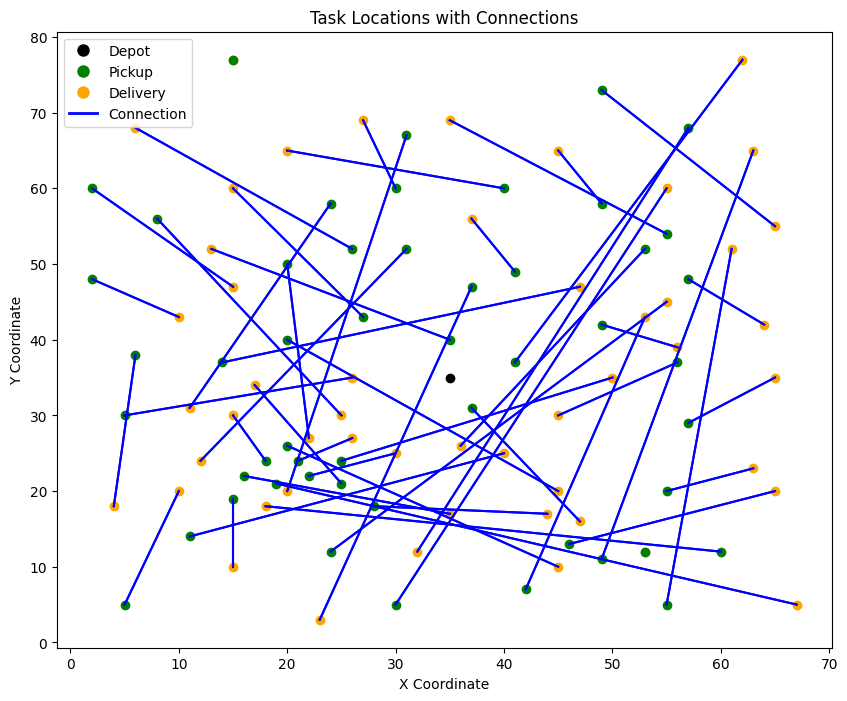

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 假设 task_df 已经被创建，并且所有列都已经转换为数值类型
# 将 'PICKUP(index to sibling)' 和 'DELIVERY(index to sibling)' 合并为 'CONNECTION' 列
task_df['CONNECTION'] = task_df[['PICKUP(index to sibling)', 'DELIVERY(index to sibling)']].max(axis=1)
task_df['CONNECTION'] = pd.to_numeric(task_df['CONNECTION'], errors='coerce').fillna(0).astype(int)

# 创建 'photos' 文件夹，如果它不存在
os.makedirs('photos', exist_ok=True)

# 先创建一个空白图
plt.figure(figsize=(10, 8))

# 遍历每一行
for _, row in task_df.iterrows():
    task_type = row['TASK TYPE']
    x, y = row['X'], row['Y']
    
    if task_type == 'depot':
        # 绘制仓库（黑色）
        plt.scatter(x, y, color='black')
    
    elif task_type in ['pickup', 'delivery']:
        # 找到对应的连接任务
        sibling_index = row['CONNECTION']
        if sibling_index > 0:
            sibling_row = task_df.iloc[sibling_index]
            sibling_x, sibling_y = sibling_row['X'], sibling_row['Y']
            
            # 绘制连接任务（绿色）
            plt.scatter(sibling_x, sibling_y, color='green' if task_type == 'pickup' else 'orange')
            
            # 绘制连接线（蓝色）
            plt.plot([x, sibling_x], [y, sibling_y], color='blue')
        else:
            # 单独绘制 pickup 或 delivery 任务
            plt.scatter(x, y, color='green' if task_type == 'pickup' else 'orange')

# 添加图例
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Depot'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Pickup'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Delivery'),
    plt.Line2D([0], [0], color='blue', lw=2, label='Connection')
])

# 设置标题和标签
plt.title('Task Locations with Connections')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')



# 显示图表
plt.grid(False)
plt.show()

In [7]:

# 创建一个空的列表来存储配对数据
pairs = []

# 遍历每一行，找到pickup和对应的delivery
for _, row in task_df.iterrows():
    if row['TASK TYPE'] == 'pickup':
        # 找到对应的delivery任务
        sibling_index = row['CONNECTION']
        sibling_row = task_df.iloc[sibling_index]
        
        # 将pickup和delivery任务配对，并存入列表
        pair = {
            'pickup_task': row['TASK NO.'],
            'pickup_x': row['X'],
            'pickup_y': row['Y'],
            'pickup_earliest_time': row['EARLIEST PICKUP/DELIVERY TIME'],
            'pickup_latest_time': row['LATEST PICKUP/DELIVERY TIME'],
            'delivery_task': sibling_row['TASK NO.'],
            'delivery_x': sibling_row['X'],
            'delivery_y': sibling_row['Y'],
            'delivery_earliest_time': sibling_row['EARLIEST PICKUP/DELIVERY TIME'],
            'delivery_latest_time': sibling_row['LATEST PICKUP/DELIVERY TIME']
        }
        pairs.append(pair)

# 将列表转换为DataFrame
pairs_df = pd.DataFrame(pairs)

# 计算每对任务之间的欧几里得距离
pairs_df['distance'] = pairs_df.apply(lambda row: np.sqrt((row['pickup_x'] - row['delivery_x'])**2 +
                                                          (row['pickup_y'] - row['delivery_y'])**2), axis=1)

# 输出配对数据
pairs_df

,pickup_task,pickup_x,pickup_y,pickup_earliest_time,pickup_latest_time,delivery_task,delivery_x,delivery_y,delivery_earliest_time,delivery_latest_time,distance
0,2,35,17,18,792,85,16,22,110,727,19.646883
1,3,55,45,289,822,42,24,12,25,292,45.276926
2,5,15,30,20,906,93,18,24,691,969,6.708204
3,6,25,30,355,574,47,8,56,34,602,31.064449
4,8,10,43,393,492,46,2,48,338,805,9.433981
5,9,55,60,394,503,15,30,5,176,299,60.415230
6,11,20,65,206,325,30,40,60,199,414,20.615528
7,12,50,35,15,725,95,25,24,14,793,27.313001
8,13,30,25,694,823,92,22,22,18,159,8.544004
9,14,15,10,32,694,91,15,19,222,964,9.000000


In [8]:
# 创建一个布尔掩码来找出取货点和送货点不重合的行
mask = ~((pairs_df['pickup_x'] == pairs_df['delivery_x']) & 
         (pairs_df['pickup_y'] == pairs_df['delivery_y']))

# 应用掩码来过滤数据
cleaned_pairs_df = pairs_df[mask].copy()

# 打印清理前后的数据行数，看看删除了多少行
print(f"Original number of rows: {len(pairs_df)}")
print(f"Number of rows after cleaning: {len(cleaned_pairs_df)}")
print(f"Removed {len(pairs_df) - len(cleaned_pairs_df)} duplicate location pairs")

# 如果需要，可以将清理后的数据帧重置索引
cleaned_pairs_df = cleaned_pairs_df.reset_index(drop=True)

# 替换原来的数据帧
pairs_df = cleaned_pairs_df
pairs_df

Original number of rows: 51
Number of rows after cleaning: 49
Removed 2 duplicate location pairs


,pickup_task,pickup_x,pickup_y,pickup_earliest_time,pickup_latest_time,delivery_task,delivery_x,delivery_y,delivery_earliest_time,delivery_latest_time,distance
0,2,35,17,18,792,85,16,22,110,727,19.646883
1,3,55,45,289,822,42,24,12,25,292,45.276926
2,5,15,30,20,906,93,18,24,691,969,6.708204
3,6,25,30,355,574,47,8,56,34,602,31.064449
4,8,10,43,393,492,46,2,48,338,805,9.433981
5,9,55,60,394,503,15,30,5,176,299,60.415230
6,11,20,65,206,325,30,40,60,199,414,20.615528
7,12,50,35,15,725,95,25,24,14,793,27.313001
8,13,30,25,694,823,92,22,22,18,159,8.544004
9,14,15,10,32,694,91,15,19,222,964,9.000000


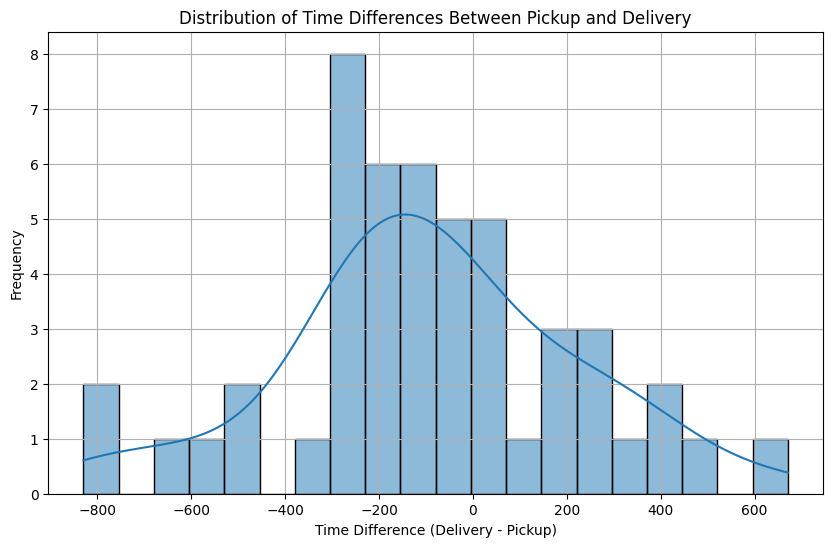

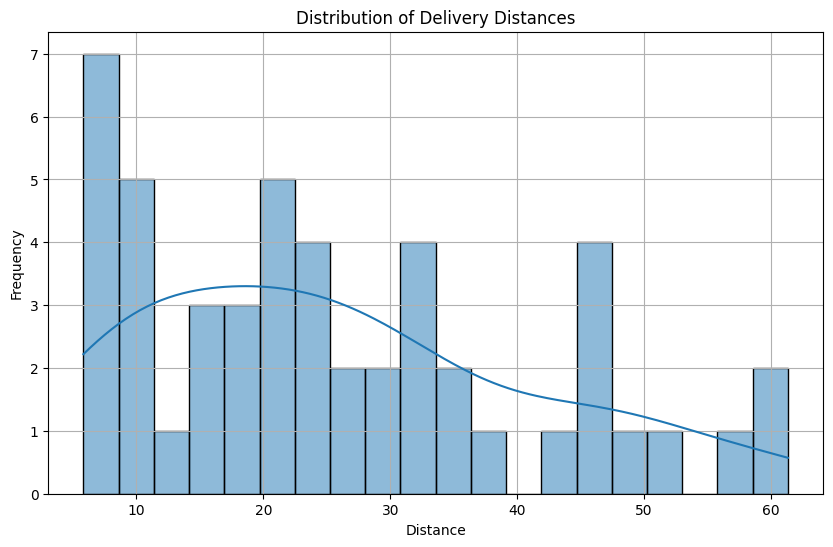

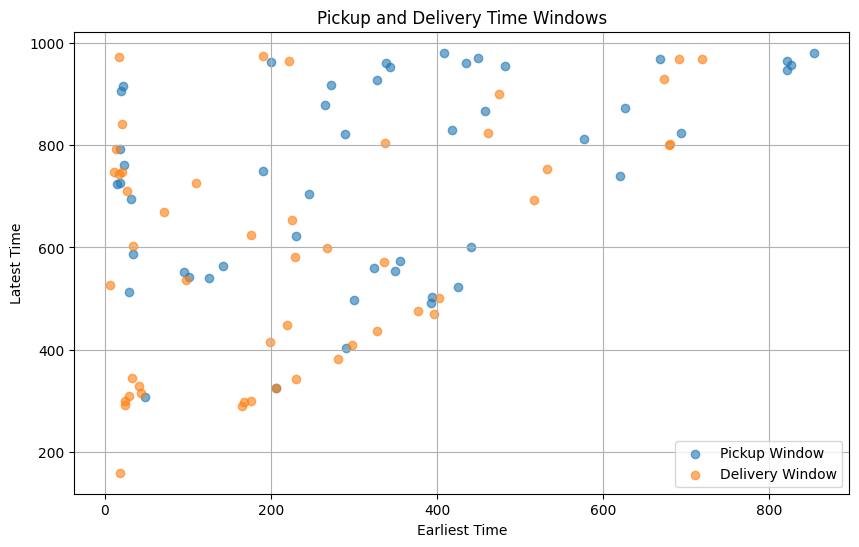

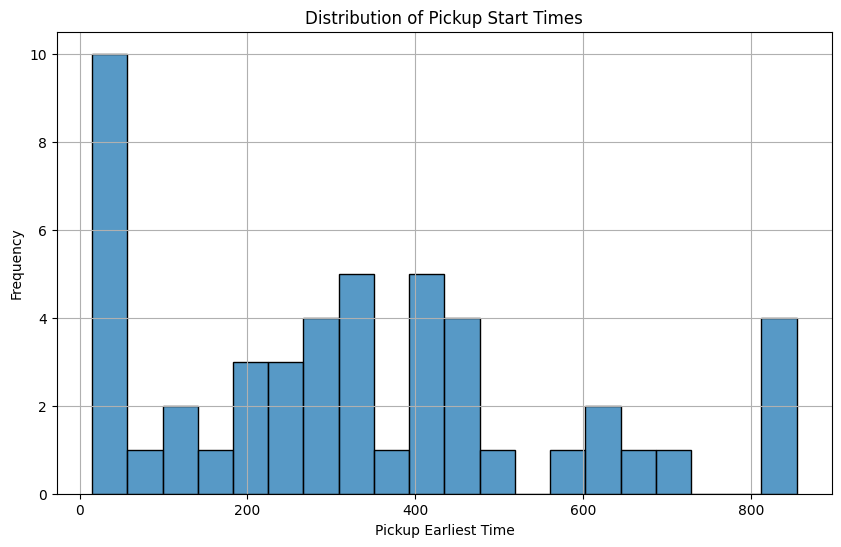

In [9]:
############整一个list或者dictionary来record，把pickup time排序，然后每个index对应一个earliest pick point，然后一个一个go through
#######可以假设有无数个delivery drones，当我有一个pick up task，然后就有一个drone在等待，如果没有等待就加一个新的drone
############下一个task是考虑delivery，就直接假设每次我开始pick up的时候就有一个drone在等待，并进行之后的deliver
import matplotlib.pyplot as plt

import seaborn as sns

# 1. 计算取货和送货的时间差
pairs_df['time_difference'] = pairs_df['delivery_earliest_time'] - pairs_df['pickup_earliest_time']

# 绘制取货和送货的时间间隔分布
plt.figure(figsize=(10, 6))
sns.histplot(pairs_df['time_difference'], bins=20, kde=True)
plt.title('Distribution of Time Differences Between Pickup and Delivery')
plt.xlabel('Time Difference (Delivery - Pickup)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 2. 绘制任务距离的分布情况
plt.figure(figsize=(10, 6))
sns.histplot(pairs_df['distance'], bins=20, kde=True)
plt.title('Distribution of Delivery Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 3. 取货/送货的时间窗口散点图
plt.figure(figsize=(10, 6))
plt.scatter(pairs_df['pickup_earliest_time'], pairs_df['pickup_latest_time'], label='Pickup Window', alpha=0.6)
plt.scatter(pairs_df['delivery_earliest_time'], pairs_df['delivery_latest_time'], label='Delivery Window', alpha=0.6)
plt.title('Pickup and Delivery Time Windows')
plt.xlabel('Earliest Time')
plt.ylabel('Latest Time')
plt.legend()
plt.grid(True)
plt.show()

# 4. 任务开始时间的条形图
plt.figure(figsize=(10, 6))
sns.histplot(pairs_df['pickup_earliest_time'], bins=20, kde=False)
plt.title('Distribution of Pickup Start Times')
plt.xlabel('Pickup Earliest Time')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [10]:
# import matplotlib.pyplot as plt
# import pandas as pd
# from matplotlib.animation import FuncAnimation

# # 假设 pairs_df 已经加载并且包含以下列：pickup_x, pickup_y, delivery_x, delivery_y, pickup_earliest_time, delivery_latest_time
# # pairs_df = pd.read_csv('your_data.csv')

# # 计算平均时间（取 earliest 和 latest 的平均值）
# pairs_df['pickup_avg_time'] = (pairs_df['pickup_earliest_time'] + pairs_df['pickup_latest_time']) / 2
# pairs_df['delivery_avg_time'] = (pairs_df['delivery_earliest_time'] + pairs_df['delivery_latest_time']) / 2

# # 动图设置
# fig, ax = plt.subplots(figsize=(10, 6))

# # 初始设置
# def init():
#     ax.set_xlim(pairs_df['pickup_x'].min() - 5, pairs_df['delivery_x'].max() + 5)
#     ax.set_ylim(pairs_df['pickup_y'].min() - 5, pairs_df['delivery_y'].max() + 5)
#     ax.set_title('Pickup and Delivery Animation')
#     ax.set_xlabel('X Coordinate')
#     ax.set_ylabel('Y Coordinate')

# # 更新函数
# def update(frame):
#     ax.clear()
#     init()
    
#     # 获取当前时间下的pickup和delivery点
#     current_pickups = pairs_df[pairs_df['pickup_avg_time'] <= frame]
#     current_deliveries = pairs_df[pairs_df['delivery_avg_time'] <= frame]
    
#     # 绘制 pickup 和 delivery 的点及连接线
#     for index, row in current_pickups.iterrows():
#         ax.scatter(row['pickup_x'], row['pickup_y'], color='green', label='Pickup' if index == 0 else "", s=50)
        
#     for index, row in current_deliveries.iterrows():
#         ax.scatter(row['delivery_x'], row['delivery_y'], color='red', label='Delivery' if index == 0 else "", s=50)
#         # 画线从pickup到delivery
#         ax.plot([row['pickup_x'], row['delivery_x']], [row['pickup_y'], row['delivery_y']], color='blue', linestyle='--', alpha=0.7)
    
#     # 设置图例
#     ax.legend()

# # 创建动画，100帧，每帧间隔200ms
# ani = FuncAnimation(fig, update, frames=range(int(pairs_df['pickup_avg_time'].min()), int(pairs_df['delivery_avg_time'].max())), init_func=init, repeat=False)

# # 保存为gif (如果需要)
# ani.save('pickup_delivery_animation.gif', writer='imagemagick', fps=10)

# # 显示动画
# plt.show()

In [11]:
import pandas as pd

# Define the bus lines with stations every 10 units
bus_stations = []

# First bus line from (10, 0) to (10, 60) to (70, 60)
for y in range(0, 60, 10):  # Cover (10,0) to (10,60) inclusive
    bus_stations.append({'line': 'Line 1', 'x': float(15), 'y': float(y)})
for x in range(15, 75, 10):  # Cover (10,60) to (70,60) inclusive
    bus_stations.append({'line': 'Line 1', 'x': float(x), 'y': float(60)})

# Second bus line from (0, 20) to (50, 20) to (50, 80)
for x in range(0, 60, 10):  # Cover (0,20) to (50,20) inclusive
    bus_stations.append({'line': 'Line 2', 'x': float(x), 'y': float(15)})
for y in range(25, 85, 10):  # Cover (50,20) to (50,80) inclusive
    bus_stations.append({'line': 'Line 2', 'x': float(50), 'y': float(y)})

# Convert to DataFrame
bus_stations_df = pd.DataFrame(bus_stations)

# Ensure columns 'x' and 'y' are of float type
bus_stations_df['x'] = bus_stations_df['x'].astype(float)
bus_stations_df['y'] = bus_stations_df['y'].astype(float)

bus_stations_df['station_index'] = bus_stations_df.groupby('line').cumcount()

# Display the DataFrame
bus_stations_df

,line,x,y,station_index
0,Line 1,15.0,0.0,0
1,Line 1,15.0,10.0,1
2,Line 1,15.0,20.0,2
3,Line 1,15.0,30.0,3
4,Line 1,15.0,40.0,4
5,Line 1,15.0,50.0,5
6,Line 1,15.0,60.0,6
7,Line 1,25.0,60.0,7
8,Line 1,35.0,60.0,8
9,Line 1,45.0,60.0,9


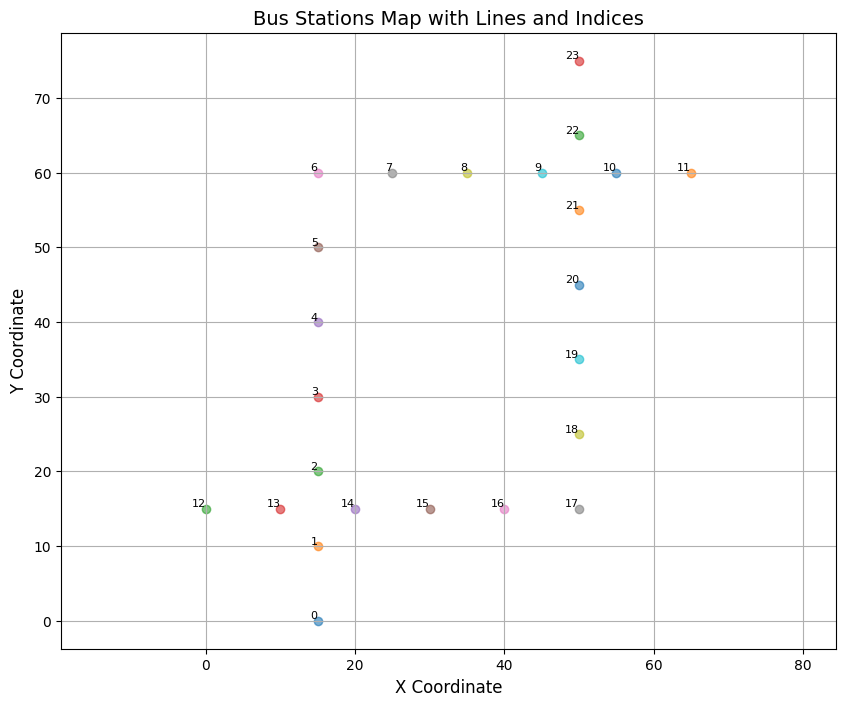

In [12]:
import pandas as pd
import matplotlib.pyplot as plt


# Ensure columns 'x' and 'y' are of float type
bus_stations_df['x'] = bus_stations_df['x'].astype(float)
bus_stations_df['y'] = bus_stations_df['y'].astype(float)

# Plot each bus station, marking its position and labeling with its line and index
plt.figure(figsize=(10, 8))

# Plot all stations
for index, row in bus_stations_df.iterrows():
    plt.scatter(row['x'], row['y'], label=f"{row['line']}" if index == 0 else "", alpha=0.6)
    plt.text(row['x'], row['y'], f"{index}", fontsize=8, ha='right', va='bottom')

# Adding labels and title
plt.title("Bus Stations Map with Lines and Indices", fontsize=14)
plt.xlabel("X Coordinate", fontsize=12)
plt.ylabel("Y Coordinate", fontsize=12)
plt.grid(True)
plt.axis("equal")

# Display the plot
plt.show()

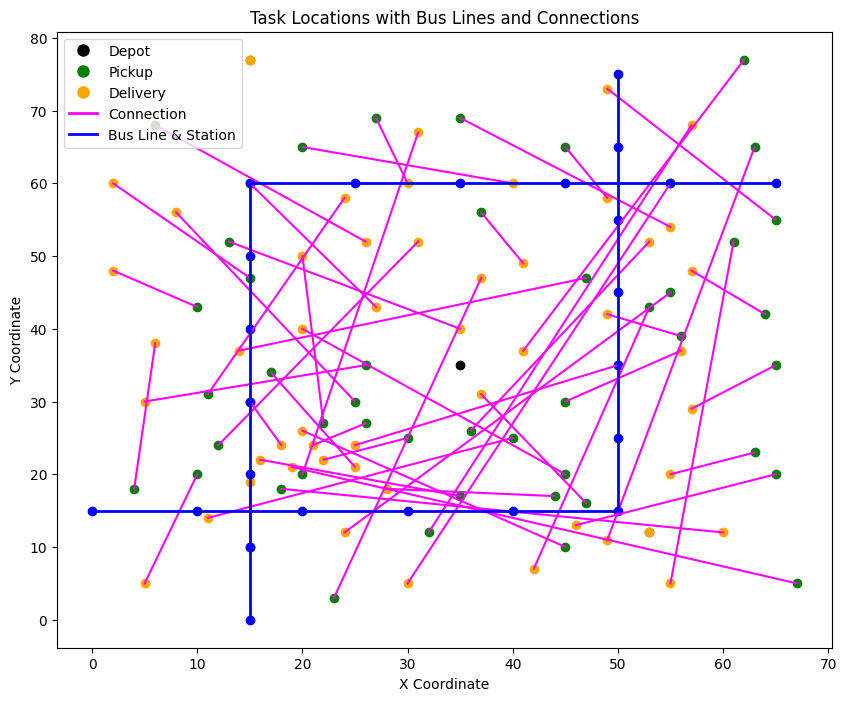

In [13]:
import matplotlib.pyplot as plt

# Existing plot setup for tasks (pickup, delivery, depot)
plt.figure(figsize=(10, 8))

# 遍历每一行，绘制pickup和delivery点及其连接
for _, row in task_df.iterrows():
    task_type = row['TASK TYPE']
    x, y = row['X'], row['Y']
    
    if task_type == 'depot':
        plt.scatter(x, y, color='black')
    elif task_type == 'pickup':
        sibling_index = row['CONNECTION']
        sibling_row = task_df.iloc[sibling_index]
        sibling_x, sibling_y = sibling_row['X'], sibling_row['Y']
        plt.scatter(x, y, color='green')
        plt.scatter(sibling_x, sibling_y, color='orange')
        plt.plot([x, sibling_x], [y, sibling_y], color='magenta')
    elif task_type == 'delivery':
        continue  # Already plotted in 'pickup' part

# Plotting the bus stations and lines
for line in bus_stations_df['line'].unique():
    line_stations = bus_stations_df[bus_stations_df['line'] == line]
    
    # Plot bus stations in red
    plt.scatter(line_stations['x'], line_stations['y'], color='blue', label=f'{line} Bus Station')

    # Draw lines connecting bus stations
    plt.plot(line_stations['x'], line_stations['y'], color='blue', linestyle='-', linewidth=2)

# Adding legends
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Depot'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Pickup'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Delivery'),
    plt.Line2D([0], [0], color='magenta', lw=2, label='Connection'),
    plt.Line2D([0], [0], color='blue', lw=2, label='Bus Line & Station')
])

# Set plot title and labels
plt.title('Task Locations with Bus Lines and Connections')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# # 保存图表到 'photos/lr210.png'
plt.savefig('photos/lr210.png')

# Display the plot
plt.grid(False)
plt.show()

In [14]:
# 假设 pairs_df 已经包含任务信息，并且具有 'pickup_earliest_time' 列
# 将任务按 'pickup_earliest_time' 从小到大排序
sorted_tasks = pairs_df.sort_values(by='pickup_earliest_time').reset_index(drop=True)

sorted_tasks = sorted_tasks.iloc[:-1]

# 创建一个列表或字典来存储排序后的任务
task_list = []

# 遍历排序后的任务，记录每个任务的索引和任务详情
for index, task in sorted_tasks.iterrows():
    task_record = {
        'index': index,
        # 'package': index,
        'pickup_task': task['pickup_task'],
        'pickup_time': task['pickup_earliest_time'],
        'delivery_task': task['delivery_task'],
        'pickup_x': task['pickup_x'],  # 单独记录 pickup_x
        'pickup_y': task['pickup_y'],  # 单独记录 pickup_y
        'delivery_x': task['delivery_x'],  # 单独记录 delivery_x
        'delivery_y': task['delivery_y'],  # 单独记录 delivery_y
        'distance': task['distance']
    }
    task_list.append(task_record)

task_list = task_list[:10]
# 输出任务列表
# for task in task_list:
#     print(f"Task {task['index']}: Pickup Task {task['pickup_task']} at {task['pickup_location']} "
#           f"from earliest time {task['pickup_time']}, Deliver to {task['delivery_location']}, "
#           f"Distance: {task['distance']}")

In [15]:
len(task_list)

10

## Bus Dataframe

In [16]:
bus_stations_df = bus_stations_df
bus_stations_df

,line,x,y,station_index
0,Line 1,15.0,0.0,0
1,Line 1,15.0,10.0,1
2,Line 1,15.0,20.0,2
3,Line 1,15.0,30.0,3
4,Line 1,15.0,40.0,4
5,Line 1,15.0,50.0,5
6,Line 1,15.0,60.0,6
7,Line 1,25.0,60.0,7
8,Line 1,35.0,60.0,8
9,Line 1,45.0,60.0,9


## Package

In [17]:
import numpy as np
from scipy.spatial.distance import cdist
from collections import deque
import math
# 查找离给定位置最近的巴士站
import numpy as np
from scipy.spatial.distance import cdist

def find_bus_station_by_rank(x, y, bus_stations, line, rank=0):
    """
    查找指定线路上离 (x, y) 第N近（从0开始）的巴士站。
    
    参数：
    - x, y: 当前坐标
    - bus_stations: 所有巴士站对象的列表
    - line: 目标线路名称
    - rank: 距离排名（0表示最近，1表示第二近，以此类推）
    
    返回：
    - 第N近的巴士站对象
    """
    # 筛选属于指定线路的巴士站
    filtered_stations = [bs for bs in bus_stations if bs.line == line]
    
    if not filtered_stations:
        raise ValueError(f"No bus stations found for line {line}.")
    
    # 使用 cdist 计算距离
    distances = cdist([(x, y)], [(bs.x, bs.y) for bs in filtered_stations])[0]
    
    # 对距离进行排序，获取排名对应的索引
    sorted_indices = np.argsort(distances)
    
    # 确保 rank 在有效范围内
    if rank >= len(filtered_stations):
        print(f"Warning: Requested rank {rank} exceeds number of available stations ({len(filtered_stations)}). Using the farthest station instead.")
        rank = len(filtered_stations) - 1
    
    # 获取第 rank 近的站点索引
    target_index = sorted_indices[rank]
    
    return filtered_stations[target_index]

# 获取指定线路上距离当前位置最近的多个巴士站及其距离
def get_nearest_stations(x, y, bus_stations, line, n=3):
    """
    返回指定线路上距离 (x, y) 最近的n个巴士站及其距离。
    
    参数：
    - x, y: 当前坐标
    - bus_stations: 所有巴士站对象的列表
    - line: 目标线路名称
    - n: 返回站点的数量
    
    返回：
    - 包含 (station, distance) 元组的列表，按距离排序
    """
    # 筛选属于指定线路的巴士站
    filtered_stations = [bs for bs in bus_stations if bs.line == line]
    
    if not filtered_stations:
        return []
    
    # 计算距离
    stations_with_distances = []
    for station in filtered_stations:
        distance = np.sqrt((x - station.x)**2 + (y - station.y)**2)
        stations_with_distances.append((station, distance))
    
    # 按距离排序
    stations_with_distances.sort(key=lambda x: x[1])
    
    # 返回最近的n个站点（或者所有站点，如果站点数量少于n）
    return stations_with_distances[:min(n, len(stations_with_distances))]

# 替换原有的 find_nearest_bus_station 函数调用
def find_nearest_bus_station(x, y, bus_stations, line, rank=0):
    """
    向后兼容的函数，在指定线路上查找离 (x, y) 第rank近的巴士站。
    默认rank=0，即返回最近的站点（保持原有行为）。
    
    参数：
    - x, y: 当前坐标
    - bus_stations: 所有巴士站对象的列表
    - line: 目标线路名称
    - rank: 距离排名（0表示最近，1表示第二近，以此类推）
    
    返回：
    - 第N近的巴士站对象
    """
    return find_bus_station_by_rank(x, y, bus_stations, line, rank)

def calculate_best_line_with_station_rank(pickup_x, pickup_y, delivery_x, delivery_y, 
                                          bus_stations, bus_lines, pickup_rank=0, delivery_rank=0):
    """
    计算最佳线路，考虑使用指定排名的巴士站。
    
    参数：
    - pickup_x, pickup_y: 取货点坐标
    - delivery_x, delivery_y: 送货点坐标
    - bus_stations: 所有巴士站对象的列表
    - bus_lines: 可用的巴士线路列表
    - pickup_rank: 取货站点的距离排名
    - delivery_rank: 送货站点的距离排名
    
    返回：
    - best_line: 最佳线路
    - min_total_distance: 最小总距离
    - pickup_station: 选择的取货站
    - delivery_station: 选择的送货站
    """
    best_line = None
    min_total_distance = float('inf')
    best_pickup_station = None
    best_delivery_station = None
    
    for line in bus_lines:
        try:
            # 根据排名选择巴士站
            pickup_station = find_bus_station_by_rank(pickup_x, pickup_y, bus_stations, line, pickup_rank)
            pickup_distance = np.sqrt((pickup_x - pickup_station.x)**2 + (pickup_y - pickup_station.y)**2)
            
            delivery_station = find_bus_station_by_rank(delivery_x, delivery_y, bus_stations, line, delivery_rank)
            delivery_distance = np.sqrt((delivery_x - delivery_station.x)**2 + (delivery_y - delivery_station.y)**2)
            
            # 计算总距离
            total_distance = pickup_distance + delivery_distance
            
            # 更新最佳线路
            if total_distance < min_total_distance:
                min_total_distance = total_distance
                best_line = line
                best_pickup_station = pickup_station
                best_delivery_station = delivery_station
        except ValueError:
            # 如果该线路没有足够的站点，跳过
            continue
    
    return best_line, min_total_distance, best_pickup_station, best_delivery_station

# 巴士站类，记录位置
class BusStation:
    def __init__(self, x, y, line):
        self.x = x
        self.y = y
        self.line = line

class Package:
    def __init__(self, package_id, task_id):
        self.package_id = package_id
        self.task_id = task_id  # Store only the task ID
        self.status = 'at_pickup_point'  # Initial status
        self.bus_id = None
        self.current_drone_id = None

    def update_status(self, new_status):
        self.status = new_status
        print(f"[DEBUG] Package {self.package_id} status updated to {self.status}.")
        old_status = self.status
        self.status = new_status
        print(f"Package {self.package_id} status changed: {old_status} -> {new_status}")

# Function to find the corresponding task by ID
def get_task_by_id(task_id):
    return next((task for task in tasks if task['index'] == task_id), None)

# Function to find the corresponding package by ID
def get_package_by_id(package_id):
    return next((package for package in packages if package.package_id == package_id), None)

# 这个函数需要在你的代码中实现，用于估计两点之间飞行消耗的电量
def estimate_battery_consumption(x1, y1, x2, y2):
    """估计从一个点飞到另一个点所需的电量"""
    # 简单实现：假设每单位距离消耗1单位电量
    distance = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
    return distance

## Bus

In [18]:


class Bus:
    def __init__(self, bus_id, route, line, start_station_index, direction, speed=2.5, stop_time=3):
        self.bus_id = bus_id
        self.line = line 
        self.route = route
        self.station_index = start_station_index
        self.direction = direction  # 1 表示向前，-1 表示向后
        self.x = self.route[self.station_index]['x']
        self.y = self.route[self.station_index]['y']
        self.speed = speed
        self.time_at_station = 0
        self.stop_time = stop_time
        self.status = 'at_station'  # 初始状态为在站点
        self.capacity = 1  # 每辆巴士的容量限制
        self.current_package = None  # 巴士当前携带的包裹

    def move(self):
        if self.status == 'at_station':
            # 等待时间逻辑
            self.time_at_station += 0.5
            if self.time_at_station >= self.stop_time:
                self.status = 'moving'
                self.time_at_station = 0
        elif self.status == 'moving':
            next_station_index = self.station_index + self.direction

            # 判断是否到达终点站
            if next_station_index < 0 or next_station_index >= len(self.route):
                # 到达终点站，反转方向
                self.direction *= -1
                next_station_index = self.station_index + self.direction

            # 计算到下一个站点的距离
            next_station = self.route[next_station_index]
            distance_to_next_station = math.sqrt(
                (self.x - next_station['x']) ** 2 + (self.y - next_station['y']) ** 2
            )

            if distance_to_next_station <= self.speed:
                # 到达下一个站点
                self.x = next_station['x']
                self.y = next_station['y']
                self.station_index = next_station_index
                self.status = 'at_station'
            else:
                # 向目标站点移动
                move_ratio = self.speed / distance_to_next_station
                self.x += move_ratio * (next_station['x'] - self.x)
                self.y += move_ratio * (next_station['y'] - self.y)

    def can_pickup_package(self):
        """检查巴士是否可以接收包裹"""
        return self.current_package is None

    def load_package(self, package):
        """加载包裹到巴士"""
        if self.can_pickup_package():
            self.current_package = package
            package.update_status('on_bus')
            print(f"Package {package.package_id} loaded onto Bus {self.bus_id}.")
        else:
            print(f"Bus {self.bus_id} is full, cannot load Package {package.package_id}.")

    def unload_package(self):
        """从巴士卸载包裹"""
        package = self.current_package
        self.current_package = None
        return package
    
    
    def check_direction(self, target_station):
        """
        检查巴士方向是否朝向目标站点。
        参数：
        - target_station: 目标站点坐标 (x, y)
        返回值：
        - True: 如果巴士行进方向最终会到达目标站点
        - False: 如果巴士行进方向不会到达目标站点
        """
        next_station_index = self.station_index + self.direction

        # 检查当前方向是否合法，非法则自动反转方向
        if next_station_index < 0 or next_station_index >= len(self.route):
            return True  # 到达终点自动反方向行驶，目标有可能在新方向上

        # 模拟沿当前方向行驶路径，检查目标站点是否在路径上
        current_index = self.station_index
        while 0 <= current_index < len(self.route):
            # 如果找到目标站点，方向正确
            station = self.route[current_index]
            if (station['x'], station['y']) == target_station:
                return True
            current_index += self.direction

        # 如果未找到目标站点，方向错误
        return False
    
    def is_on_target_line(self, target_line):
        """
        检查巴士是否在目标线路上。
        :param target_line: 目标线路名称
        :return: True 如果巴士属于目标线路，否则 False
        """
        return self.line == target_line


## Bus system

In [19]:
class BusSystem:
    def __init__(self):

        self.tasks_transported = 0  # 统计巴士运输的次数
        self.buses = []  # 公交车列表
        self.bus_id_counter = 0  # 用来给每辆公交车分配唯一ID
        self.time = 0  # 系统的全局时间


    def simulate(self, bus_lines, bus_stations_df):
        """每隔50个时间单位发车一次，并更新公交车的位置"""
        # 每隔50个时间单位添加新的公交车
        if self.time % 10 == 0 and self.time <= 50:
            # print(f"Starting new buses on all lines at time {self.time}.")
            self.initialize_buses(bus_lines, bus_stations_df)

        # 更新所有公交车的位置
        self.update_buses()
        self.time += 0.5  # 时间步长

    def initialize_buses(self, bus_lines, bus_stations_df):
        """初始化每条线路的巴士"""
        for line in bus_lines:
            # 获取并排序线路站点
            route_stations = sorted(
                [station for station in bus_stations_df.to_dict('records') if station['line'] == line],
                key=lambda s: s['station_index']
            )
            # print(f"Initializing buses for {line}: {route_stations}")

            # 确保第一个和最后一个站点被正确初始化
            # 初始化巴士
            if len(route_stations) > 1:
                # 在第一站生成一个向前行驶的巴士
                self.buses.append(Bus(
                    bus_id=self.bus_id_counter,
                    line=line,   # <-- 必须加上
                    route=route_stations,
                    start_station_index=0,
                    direction=1
                ))
                self.bus_id_counter += 1

                # 最后一站生成一个向后行驶的巴士
                self.buses.append(Bus(
                    bus_id=self.bus_id_counter,
                    line=line,   # <-- 必须加上
                    route=route_stations,
                    start_station_index=len(route_stations) - 1,
                    direction=-1
                ))
                self.bus_id_counter += 1


    def update_buses(self):
        """更新所有公交车的位置"""
        for bus in self.buses:
            bus.move()
            # print(f"Bus {bus.bus_id} at ({bus.x}, {bus.y}), Status: {bus.status}, Direction: {bus.direction}")

    
    def check_buses_at_station_for_pickup(self, x, y, line=None, delivery_station=None):
        """
        检查指定位置是否有公交车可以用于取包裹，并确保方向正确。
        如果提供了线路信息，则只检查属于该线路的公交车。
        
        参数:
        - x, y: 公交站的坐标（取货站点，或无人机正等车的站点）
        - line: 可选，指定线路名称
        - delivery_station: 目标送货站点 (x, y)
        
        返回:
        - 匹配的公交车对象，如果没有找到返回 None
        """
        for bus in self.buses:
            if bus.x == x and bus.y == y:
                # 如果提供了线路信息，先检查巴士是否在目标线路上
                if line is not None and not bus.is_on_target_line(line):
                    continue
                
                # 如果给定了目标送货站点，需要检查巴士方向
                if delivery_station is not None:
                    if not bus.check_direction(delivery_station):
                        continue
                
                # 如果通过以上检查，返回这辆巴士
                return bus
        
        return None

    def check_buses_at_station_for_delivery(self, x, y, bus_id):
        for bus in self.buses:
            if bus.x == x and bus.y == y and bus.bus_id == bus_id:
                return bus
        return None

## Drone

In [ ]:
class Drone:
    def __init__(self, drone_id, region, x, y, speed=5):
        self.drone_id = drone_id
        self.region = region  # 无人机负责的区域编号
        self.x = x
        self.y = y
        self.speed = speed

        # --- 原有属性 ---
        self.status = 'idle'  
        self.current_task = None  
        self.target_x = None
        self.target_y = None
        self.time_until_idle = 0  
        self.delivery_tasks_completed = 0  
        self.pickup_tasks_completed = 0  
        self.bus_id = None  

        # --- 新增属性：电量相关 ---
        self.battery_capacity = 300.0  # 假设最大续航对应300米/单位距离
        self.battery_left = 300.0      # 初始电量充满
        self.charging_station_x = 35
        self.charging_station_y = 35
        self.is_going_to_charge = False
        
        # --- 新增路径规划相关属性 ---
        # 添加路径规划相关的属性
        self.future_stops = []  # [(x, y), ...] - 无人机未来会停靠的位置
        self.max_tasks = 5     # 单个无人机最多安排的任务数量

    def add_future_stop(self, x, y, estimated_time=None):
        """添加一个未来的停靠点，包含预计到达时间"""
        if estimated_time is None:
            # 如果没有提供预计时间，根据当前位置计算
            if not self.future_stops:
                current_x, current_y = self.x, self.y
                current_time = 0
            else:
                current_x, current_y, current_time = self.future_stops[-1]
            
            distance = math.sqrt((x - current_x)**2 + (y - current_y)**2)
            estimated_time = current_time + math.ceil(distance / self.speed)
        
        self.future_stops.append((x, y, estimated_time))
    
    def get_future_stops_count(self):
        """获取未来停靠点数量"""
        return len(self.future_stops)
    
    def clear_future_stops(self):
        """清空未来停靠点"""
        self.future_stops = []




        
    def has_sufficient_battery(self, target_x, target_y, final_destination_x=None, final_destination_y=None):
        """
        评估无人机是否有足够电量完成目标任务，如电量不足则立即转为充电模式
        
        参数:
        - target_x, target_y: 初始目标点坐标
        - final_destination_x, final_destination_y: 最终目的地坐标(如果有)
        
        返回:
        - True: 如果电量足够
        - False: 如果电量不足，并且已经切换到充电模式
        """
        # 计算当前位置到目标点的距离
        distance_to_target = math.sqrt((self.x - target_x)**2 + (self.y - target_y)**2)
        
        # 安全裕量，确保有足够电量返回充电站
        safety_margin = 50
        
        # 计算从目标点到充电站的距离
        distance_target_to_charger = math.sqrt(
            (target_x - self.charging_station_x)**2 + 
            (target_y - self.charging_station_y)**2
        )
        
        # 如果有最终目的地(如在直接运输任务中)
        if final_destination_x is not None and final_destination_y is not None:
            # 计算从初始目标到最终目的地的距离
            distance_target_to_final = math.sqrt(
                (target_x - final_destination_x)**2 + 
                (target_y - final_destination_y)**2
            )
            
            # 计算从最终目的地到充电站的距离
            distance_final_to_charger = math.sqrt(
                (final_destination_x - self.charging_station_x)**2 + 
                (final_destination_y - self.charging_station_y)**2
            )
            
            # 总预估距离
            total_distance = distance_to_target + distance_target_to_final + distance_final_to_charger
            
            # 判断电量是否足够完成整个任务并返回充电站
            has_enough = self.battery_left >= (total_distance + safety_margin)
        else:
            # 判断电量是否足够到达目标点并返回充电站
            total_distance = distance_to_target + distance_target_to_charger
            
            # 如果低于安全阈值，直接返回False
            if self.battery_left < safety_margin or total_distance > self.battery_left:
                has_enough = False
            else:
                has_enough = self.battery_left >= (total_distance + safety_margin)
        
        # 如果电量不足，立即切换到充电模式
        if not has_enough and self.status != 'to_charging_station':
            self._switch_to_charging()
            print(f"Drone {self.drone_id} has insufficient battery. Switching to charging mode.")
        
        return has_enough


    def assign_pickup_task(self, task, target_x, target_y, line, station_rank=0):
        """分配取货任务，并设置目标位置"""
        # 首先检查电量是否足够
        if not self.has_sufficient_battery(target_x, target_y):
            print(f"Drone {self.drone_id} has insufficient battery for pickup task to ({target_x}, {target_y}). Current battery: {self.battery_left}")
            return False
            
        self.current_task = task
        self.status = 'moving_to_pickup'
        self.target_x = target_x
        self.target_y = target_y
        self.current_task['line'] = line  # 确保任务携带线路信息
        self.current_task['station_rank'] = station_rank  # 记录使用的站点排名
        package = get_package_by_id(task['package_id'])
        if package:
            package.current_drone_id = self.drone_id  

        # 计算欧拉距离并考虑速度
        distance_to_target = math.sqrt((self.target_x - self.x)**2 + (self.target_y - self.y)**2)
        self.time_until_idle = int(math.ceil(distance_to_target / self.speed))
        
        # 添加未来停靠点，包含时间估计
        current_time = self.time_until_idle
        self.add_future_stop(target_x, target_y, current_time)  # 取货点
        
        # 找到最近的巴士站
        nearest_station = find_nearest_bus_station(
            target_x, target_y, bus_stations, line, station_rank
        )
        
        # 计算从取货点到巴士站的时间
        distance_to_station = math.sqrt((target_x - nearest_station.x)**2 + (target_y - nearest_station.y)**2)
        time_to_station = int(math.ceil(distance_to_station / self.speed))
        current_time += time_to_station
        
        self.add_future_stop(nearest_station.x, nearest_station.y, current_time)  # 巴士站
        return True

    def assign_delivery_task(self, task, target_x, target_y, line, station_rank=0):
        """分配送货任务，设置目标位置为离送货点最近的巴士站"""
        # 首先检查电量是否足够
        if not self.has_sufficient_battery(target_x, target_y):
            print(f"Drone {self.drone_id} has insufficient battery for delivery task to ({target_x}, {target_y}). Current battery: {self.battery_left}")
            return False
            
        self.current_task = task
        self.status = 'moving_to_bus_station_for_delivery'
        self.target_x = target_x
        self.target_y = target_y
        self.current_task['line'] = line  # 确保任务携带线路信息
        self.current_task['station_rank'] = station_rank  # 记录使用的站点排名

        # 计算欧拉距离并考虑速度
        distance_to_target = math.sqrt((self.target_x - self.x)**2 + (self.target_y - self.y)**2)
        self.time_until_idle = int(math.ceil(distance_to_target / self.speed))
        
        # 添加未来停靠点，包含时间估计
        current_time = self.time_until_idle
        self.add_future_stop(target_x, target_y, current_time)  # 巴士站
        
        # 计算从巴士站到送货点的时间
        distance_to_delivery = math.sqrt((target_x - task['delivery_x'])**2 + (target_y - task['delivery_y'])**2)
        time_to_delivery = int(math.ceil(distance_to_delivery / self.speed))
        current_time += time_to_delivery
        
        self.add_future_stop(task['delivery_x'], task['delivery_y'], current_time)  # 送货点
        return True

    def assign_direct_transport(self, task, pickup_x, pickup_y, delivery_x, delivery_y):
        """分配直接运输任务"""
        # 检查电量是否足够完成整个直接运输任务
        if not self.has_sufficient_battery(pickup_x, pickup_y, delivery_x, delivery_y):
            print(f"Drone {self.drone_id} has insufficient battery for direct transport from ({pickup_x}, {pickup_y}) to ({delivery_x}, {delivery_y}). Current battery: {self.battery_left}")
            return False
            
        self.current_task = task
        self.status = 'direct_transport_to_pickup'
        self.target_x = pickup_x
        self.target_y = pickup_y

        # 计算到达取货点的距离
        distance_to_pickup = math.sqrt((self.x - pickup_x)**2 + (self.y - pickup_y)**2)
        self.time_until_idle = int(math.ceil(distance_to_pickup / self.speed))

        # 存储送货点坐标到任务中
        self.current_task['delivery_x'] = delivery_x
        self.current_task['delivery_y'] = delivery_y
        
        # 添加未来停靠点，包含时间估计
        current_time = self.time_until_idle
        self.add_future_stop(pickup_x, pickup_y, current_time)  # 取货点
        
        # 计算从取货点到送货点的时间
        distance_to_delivery = math.sqrt((pickup_x - delivery_x)**2 + (pickup_y - delivery_y)**2)
        time_to_delivery = int(math.ceil(distance_to_delivery / self.speed))
        current_time += time_to_delivery
        
        self.add_future_stop(delivery_x, delivery_y, current_time)  # 送货点
        
        print(f"Drone {self.drone_id} assigned direct transport from ({pickup_x}, {pickup_y}) to ({delivery_x}, {delivery_y}).")
        return True

    def move(self, current_time):
        """
        Unified drone movement logic with integrated battery management.
        统一状态处理模式，将充电逻辑集成到状态系统中
        """

        if self.status == 'idle' or self.time_until_idle <= 0:
            return
            
        # 确定目标位置 - 根据当前状态决定移动目标
        if self.status == 'to_charging_station':
            target_x, target_y = self.charging_station_x, self.charging_station_y
        else:
            target_x, target_y = self.target_x, self.target_y
        
        # 计算到目标的距离
        dist_to_target = math.sqrt((target_x - self.x)**2 + (target_y - self.y)**2)
        
        # 判断是否可以直接到达目标
        if dist_to_target <= self.speed:
            # 本次可直接到达目标
            self.x = target_x
            self.y = target_y
            
            # 消耗对应的电量
            self.battery_left -= dist_to_target
            
            # 防御性判断，确保电量不会为负
            if self.battery_left < 0:
                self.battery_left = 0
                
            # 处理到达目标后的逻辑
            self._handle_arrival(current_time)
        else:
            # 距离目标还比较远，就走一小步
            move_ratio = self.speed / dist_to_target
            move_x = move_ratio * (target_x - self.x)
            move_y = move_ratio * (target_y - self.y)
            self.x += move_x
            self.y += move_y
            
            # 消耗电量
            distance_this_step = math.sqrt(move_x**2 + move_y**2)
            self.battery_left -= distance_this_step
            
            # 更新剩余时间（非充电状态下）
            if self.status != 'to_charging_station':
                self.time_until_idle = max(self.time_until_idle - 1, 0)
            
            # 防御性判断，确保电量不会为负
            if self.battery_left < 0:
                self.battery_left = 0
                
            # 打印移动信息（可选）
            if self.status == 'to_charging_station':
                print(f"Drone {self.drone_id} moving to charging station. Battery left: {self.battery_left:.2f}")
            else:
                print(f"Drone {self.drone_id} moving to target. Battery left: {self.battery_left:.2f}")
                
            # 检查电量是否足够继续执行任务
            # 如果在普通移动模式下，且电量低于阈值，切换到充电模式
            if self.status != 'to_charging_station' and self._should_charge():
                self._switch_to_charging()


    def _handle_charging_movement(self):
        """处理飞往充电站的移动逻辑"""
        dist_to_station = math.sqrt((self.x - self.charging_station_x)**2 + (self.y - self.charging_station_y)**2)
        
        if dist_to_station <= self.speed:
            # 本次可直接到达充电桩
            self.x = self.charging_station_x
            self.y = self.charging_station_y

            # 充电完成
            self.battery_left = self.battery_capacity
            self.is_going_to_charge = False
            
            # 将状态设为idle，允许接受新任务
            self.status = "idle"
            self.time_until_idle = 0
            print(f"Drone {self.drone_id} has recharged and is ready for new tasks.")
        else:
            # 距离充电桩还比较远，就走一小步
            move_ratio = self.speed / dist_to_station
            move_x = move_ratio * (self.charging_station_x - self.x)
            move_y = move_ratio * (self.charging_station_y - self.y)

            self.x += move_x
            self.y += move_y

            # 记得消耗电量
            distance_this_step = math.sqrt(move_x**2 + move_y**2)
            self.battery_left -= distance_this_step
            print(f"Drone {self.drone_id} moving to charging station. Battery left: {self.battery_left:.2f}")

            # 防御性判断，确保电量不会为负
            if self.battery_left < 0:
                self.battery_left = 0

    def _handle_normal_movement(self, current_time):
        """处理常规移动并检查电量"""
        # 检查电量是否足够
        distance_to_target = math.sqrt((self.target_x - self.x)**2 + (self.target_y - self.y)**2)
        
        # 电量不足以完成任务或低于安全阈值，转为充电状态
        # if distance_to_target > self.battery_left:
        #     self._switch_to_charging()
        #     return
            
        # 电量够，继续移动
        step_distance = min(distance_to_target, self.speed)
        if step_distance == 0:
            return

        move_ratio = step_distance / distance_to_target
        move_x = move_ratio * (self.target_x - self.x)
        move_y = move_ratio * (self.target_y - self.y)
        
        self.x += move_x
        self.y += move_y

        # 更新电量和剩余时间
        self.battery_left -= step_distance
        self.time_until_idle = max(self.time_until_idle - 1, 0)

        # 检查是否到达目标
        if abs(self.x - self.target_x) < 1e-7 and abs(self.y - self.target_y) < 1e-7:
            self._on_arrival_logic(current_time)


    def _should_charge(self):
        """判断是否需要去充电"""
        # 计算到目标的距离
        dist_to_target = math.sqrt((self.target_x - self.x)**2 + (self.target_y - self.y)**2)
        
        # 如果当前电量不足以到达目标，或者低于安全阈值，返回True
        safe_battery_threshold = 0.2 * self.battery_capacity  # 示例：20%的电量作为安全阈值
        return dist_to_target > self.battery_left or self.battery_left < safe_battery_threshold

    def _switch_to_charging(self):
        """转换到充电状态，保存当前任务信息"""
        # 保存当前任务信息，以便充电后继续

        
        # 切换到充电状态
        self.status = 'to_charging_station'
        print(f"Drone {self.drone_id} battery low ({self.battery_left:.2f}), switching to charging mode...")

    def _handle_arrival(self, current_time):

        if self.status == 'to_charging_station':
            # 充电完成
            self.battery_left = self.battery_capacity
            # 将状态设为idle，允许接受新任务
            self.status = "idle"
            self.time_until_idle = 0
            print(f"Drone {self.drone_id} has recharged and is ready for new tasks.")

        if self.status == 'moving_to_pickup':
            # 记录取货开始时间
            if 'pickup_start_time' not in self.current_task or self.current_task['pickup_start_time'] is None:
                self.current_task['pickup_start_time'] = current_time
            
            # 原有逻辑
            package = get_package_by_id(self.current_task['package_id'])
            if package:
                package.update_status('on_pickup_drone')
                package.current_drone_id = self.drone_id  
                
            nearest_bus_station = find_nearest_bus_station(self.current_task['pickup_x'], self.current_task['pickup_y'],   
                                        bus_stations, self.current_task['line'], self.current_task['pickup_station_rank'])
            if (self.current_task['pickup_x'] == nearest_bus_station.x and 
                self.current_task['pickup_y'] == nearest_bus_station.y):
                # If pickup point is at the bus station, go directly to waiting for bus
                self.status = 'waiting_at_bus_station_for_pickup_bus'
                self.current_task['pickup_status'] = 'waiting_for_bus'
            else:
                # Move to nearest bus station after pickup
                self.status = 'moving_to_bus_station_finish_pickup'
                self.target_x, self.target_y = nearest_bus_station.x, nearest_bus_station.y
                distance_to_target = np.sqrt((self.target_x - self.x)**2 + (self.target_y - self.y)**2)
                self.time_until_idle = int(np.ceil(distance_to_target / self.speed))


        elif self.status == 'moving_to_bus_station_finish_pickup':
            # 检查最近的取货点是否也是送货点
            nearest_pickup_bus_station = find_nearest_bus_station(self.current_task['pickup_x'], self.current_task['pickup_y'], 
                                bus_stations, self.current_task['line'], self.current_task['pickup_station_rank'])
            if (self.current_task['delivery_x'] == nearest_pickup_bus_station.x and 
                self.current_task['delivery_y'] == nearest_pickup_bus_station.y):
                # 如果取货点和送货点是同一个站点，则直接完成送货任务
                self.status = 'idle'
                self.delivery_tasks_completed += 1
                self.current_task['pickup_status'] = 'completed'
                self.current_task['delivery_status'] = 'completed'
                
                # 记录取货和送货完成时间
                self.current_task['pickup_complete_time'] = current_time
                self.current_task['delivery_complete_time'] = current_time
                
                if 'package_id' in self.current_task and self.current_task['package_id'] is not None:
                    package = get_package_by_id(self.current_task['package_id'])
                    if package is not None:
                        package.update_status('delivered')
                        print(f"Package {package.package_id} has been delivered directly at the pickup point.")
                    else:
                        print(f"错误: 未找到 package_id 为 {self.current_task['package_id']} 的包裹。")

                # 清除当前任务
                self.current_task = None
                self.target_x = None
                self.target_y = None
            else:
                # 否则，设置状态为等待巴士接取
                self.status = 'waiting_at_bus_station_for_pickup_bus'
                self.current_task['pickup_status'] = 'waiting_for_bus'
                
                # 记录取货完成时间
                self.current_task['pickup_complete_time'] = current_time
                
                print(f"Drone {self.drone_id} is now waiting at the bus station ({self.x}, {self.y}) for the pickup bus.")

        elif self.status == 'moving_to_bus_station_for_delivery':
            # 记录送货开始时间
            if 'delivery_start_time' not in self.current_task or self.current_task['delivery_start_time'] is None:
                self.current_task['delivery_start_time'] = current_time
            
            # 原有逻辑
            nearest_bus_station = find_nearest_bus_station(self.current_task['delivery_x'], self.current_task['delivery_y'], 
                                        bus_stations, self.current_task['line'], self.current_task['station_rank'])
            if (self.current_task['delivery_x'] == nearest_bus_station.x and 
                self.current_task['delivery_y'] == nearest_bus_station.y):
                # If delivery point is at the bus station, go directly to idle
                self.status = 'idle'
                self.delivery_tasks_completed += 1
                self.current_task['delivery_status'] = 'completed'
                
                # 记录送货完成时间
                self.current_task['delivery_complete_time'] = current_time
                
                if 'package_id' in self.current_task and self.current_task['package_id'] is not None:
                    package = get_package_by_id(self.current_task['package_id'])
                    if package:
                        package.update_status('delivered')
                        print(f"Package {package.package_id} has been delivered.")
                    else:
                        print(f"错误: 未找到 package_id 为 {self.current_task['package_id']} 的包裹。")

                self.current_task = None
                self.target_x = None
                self.target_y = None
            else:
                # Reached delivery bus station, set waiting status
                self.current_task['delivery_status'] = 'waiting_for_bus'
                self.status = 'waiting_at_bus_station_for_delivery'

        elif self.status == 'waiting_at_bus_station_for_pickup_bus':
            # Waiting at bus station for package arrival
            pass

        elif self.status == 'waiting_at_bus_station_for_delivery':
            # Waiting at bus station for package arrival
            pass

        elif self.status == 'moving_to_delivery':
            # Reached final destination
            self.status = 'idle'
            self.delivery_tasks_completed += 1
            self.current_task['delivery_status'] = 'completed'
            
            # 记录送货完成时间
            self.current_task['delivery_complete_time'] = current_time
            
            if 'package_id' in self.current_task and self.current_task['package_id'] is not None:
                package = get_package_by_id(self.current_task['package_id'])
                if package:
                    package.update_status('delivered')
                    print(f"Package {package.package_id} has been delivered.")
                else:
                    print(f"错误: 未找到 package_id 为 {self.current_task['package_id']} 的包裹。")

            self.current_task = None
            self.target_x = None
            self.target_y = None
            
        elif self.status == 'direct_transport_to_pickup':
            if self.x == self.target_x and self.y == self.target_y:
                # 记录直接运输开始时间
                if 'direct_start_time' not in self.current_task or self.current_task['direct_start_time'] is None:
                    self.current_task['direct_start_time'] = current_time
                
                # 更改状态为直接运输到送货点
                self.status = 'direct_transport_to_delivery'
                self.target_x = self.current_task['delivery_x']
                self.target_y = self.current_task['delivery_y']
                
                # 计算到送货点的距离并更新time_until_idle
                distance_to_delivery = math.sqrt(
                    (self.x - self.target_x)**2 + 
                    (self.y - self.target_y)**2
                )
                self.time_until_idle = int(math.ceil(distance_to_delivery / self.speed))
                
                # 更新包裹状态
                if 'package_id' in self.current_task and self.current_task['package_id'] is not None:
                    package = get_package_by_id(self.current_task['package_id'])
                    if package:
                        package.update_status('on_direct_drone')
                        package.current_drone_id = self.drone_id  
                        print(f"Package {package.package_id} picked up for direct transport by Drone {self.drone_id}")


        elif self.status == 'direct_transport_to_delivery':
            # 无人机到达直接运输的送货点
            if self.x == self.target_x and self.y == self.target_y:
                # 完成直接运输任务
                self.status = 'idle'
                self.delivery_tasks_completed += 1
                self.pickup_tasks_completed += 1
                self.current_task['pickup_status'] = 'completed'
                self.current_task['delivery_status'] = 'completed'
                
                # 记录直接运输完成时间
                self.current_task['direct_complete_time'] = current_time

                if 'package_id' in self.current_task and self.current_task['package_id'] is not None:
                    package = get_package_by_id(self.current_task['package_id'])
                    if package:
                        package.update_status('directly_delivered')
                        print(f"Package {package.package_id} delivered directly by Drone {self.drone_id}.")

                # 清除当前任务
                self.current_task = None
                self.target_x = None
                self.target_y = None
                print(f"Drone {self.drone_id} is now idle after completing direct transport.")

## Drone Fleet

In [2]:
class DroneFleet:
    def __init__(self, initial_drone_count=1):
        self.drones = [Drone(i, 'pickup', 35, 35) for i in range(initial_drone_count)]
        self.drone_count = initial_drone_count
        self.pickup_task_queue = deque()
        self.delivery_task_queue = deque()
        self.direct_task_queue = deque()
        # 为批量任务处理添加缓冲区
        self.pending_tasks = []
        self.batch_size = 3  # 默认批量处理3个任务
        
    def get_idle_drones(self):
        """返回所有空闲且不在充电的无人机"""
        return [drone for drone in self.drones if drone.status == 'idle' and not drone.status == 'to_charging_station']
    
    def get_all_available_drones(self):
        """返回所有可以接受新任务的无人机，包括正在充电的无人机"""
        return self.drones  # 所有无人机都可以接受未来任务
    
    def create_new_drone(self):
        """创建一个新的无人机并返回它"""
        new_drone = Drone(self.drone_count, 'pickup', 35, 35)  # 假设新无人机从(35,35)出发
        self.drones.append(new_drone)
        self.drone_count += 1
        print(f"Created new drone with ID {new_drone.drone_id}.")
        return new_drone

    def calculate_distance(self, x1, y1, x2, y2):
        """计算两点之间的欧式距离"""
        return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
    
    def calculate_path_distance(self, path):
        """计算路径的总距离"""
        total_distance = 0
        for i in range(1, len(path)):
            total_distance += self.calculate_distance(path[i-1][0], path[i-1][1], path[i][0], path[i][1])
        return total_distance


    
        
    def try_allocate_pickup_task(self, task, target_x, target_y, station_rank=0):
        """
        尝试分配取货任务，尝试所有可用的无人机直到成功或全部失败
        """
        # 使用指定排名查找巴士站
        nearest_station = find_nearest_bus_station(target_x, target_y, bus_stations, task['line'], station_rank)
        idle_drones = self.get_idle_drones()

        # 检查是否有空闲无人机
        if not idle_drones:
            print(f"No idle drones available for pickup task {task['pickup_task']}.")
            return False

        # 为每个无人机计算到目标点的距离，并排序
        drone_distances = []
        for drone in idle_drones:
            distance = self.calculate_distance(drone.x, drone.y, target_x, target_y)
            drone_distances.append((drone, distance))
        
        # 按距离排序
        drone_distances.sort(key=lambda x: x[1])

        # 尝试分配给每一个空闲无人机，直到成功或所有无人机都尝试过
        for drone, _ in drone_distances:
            # 分配取货任务到无人机，包含电量检查
            success = drone.assign_pickup_task(task, target_x, target_y, task['line'], station_rank)
            if success:
                task['pickup_status'] = 'assigned'
                task['station_rank'] = station_rank  # 记录使用的站点排名

                if 'package_id' in task and task['package_id'] is not None:
                    package = get_package_by_id(task['package_id'])
                    if package:
                        package.update_status('on_pickup_drone')

                print(f"Assigned pickup task {task['pickup_task']} to Drone {drone.drone_id} at ({target_x}, {target_y}) using station rank {station_rank}.")
                return True
            else:
                print(f"Failed to assign pickup task {task['pickup_task']} to Drone {drone.drone_id} due to insufficient battery. Trying next drone.")
                
        # 如果所有无人机都尝试失败，返回False
        print(f"All available drones failed to execute pickup task {task['pickup_task']} due to insufficient battery.")
        return False

    def try_allocate_delivery_task(self, task, target_x, target_y, auto_create_drone=False, station_rank=0):
        """
        尝试分配送货任务，尝试所有可用的无人机直到成功或全部失败
        """
        # 使用指定排名查找巴士站
        nearest_station = find_nearest_bus_station(target_x, target_y, bus_stations, task['line'], station_rank)
        idle_drones = self.get_idle_drones()

        # 检查是否有空闲无人机
        if not idle_drones:
            if auto_create_drone:
                # 如果允许自动创建无人机，创建一个新的
                new_drone = self.create_new_drone()
                success = new_drone.assign_delivery_task(task, nearest_station.x, nearest_station.y, task['line'], station_rank)
                if success:
                    task['delivery_status'] = 'assigned'
                    task['station_rank'] = station_rank  # 记录使用的站点排名
                    print(f"Created new Drone {new_drone.drone_id} and assigned delivery task with station rank {station_rank}.")
                    return True
                else:
                    print(f"Failed to assign delivery task to new Drone {new_drone.drone_id} due to insufficient battery.")
                    return False
            else:
                # 没有可用无人机且不允许创建新无人机
                print(f"No available drone for delivery task {task['pickup_task']}.")
                return False

        # 如果送货点位于巴士站，则直接标记任务完成
        if nearest_station.x == target_x and nearest_station.y == target_y:
            # 选择第一个空闲无人机来标记完成
            if idle_drones:
                task['delivery_status'] = 'completed'
                idle_drones[0].delivery_tasks_completed += 1
                print(f"Delivery task {task['pickup_task']} completed directly at the bus station ({target_x}, {target_y}).")
                return True

        # 为每个无人机计算到目标点的距离，并排序
        drone_distances = []
        for drone in idle_drones:
            distance = self.calculate_distance(drone.x, drone.y, nearest_station.x, nearest_station.y)
            drone_distances.append((drone, distance))
        
        # 按距离排序
        drone_distances.sort(key=lambda x: x[1])

        # 尝试分配给每一个空闲无人机，直到成功或所有无人机都尝试过
        for drone, _ in drone_distances:
            # 分配送货任务到无人机，包含电量检查
            success = drone.assign_delivery_task(task, nearest_station.x, nearest_station.y, task['line'], station_rank)
            if success:
                task['delivery_status'] = 'assigned'
                task['station_rank'] = station_rank  # 记录使用的站点排名
                print(f"Assigned delivery task {task['pickup_task']} to Drone {drone.drone_id} using station rank {station_rank}.")
                return True
            else:
                print(f"Failed to assign delivery task {task['pickup_task']} to Drone {drone.drone_id} due to insufficient battery. Trying next drone.")
        
        # 如果所有无人机都尝试失败，并且允许创建新无人机
        if auto_create_drone:
            new_drone = self.create_new_drone()
            success = new_drone.assign_delivery_task(task, nearest_station.x, nearest_station.y, task['line'], station_rank)
            if success:
                task['delivery_status'] = 'assigned'
                task['station_rank'] = station_rank
                print(f"Created new Drone {new_drone.drone_id} and assigned delivery task with station rank {station_rank}.")
                return True
            else:
                print(f"Failed to assign delivery task to new Drone {new_drone.drone_id} due to insufficient battery.")
        
        # 如果所有无人机都尝试失败，返回False
        print(f"All available drones failed to execute delivery task {task['pickup_task']} due to insufficient battery.")
        return False

    def try_allocate_direct_transport(self, task, pickup_x, pickup_y, delivery_x, delivery_y):
        """直接分配无人机从取货点送到送货点，尝试所有可用的无人机直到成功或全部失败"""
        idle_drones = self.get_idle_drones()

        # 检查是否有空闲无人机
        if not idle_drones:
            # print(f"No idle drone available for direct transport task {task['pickup_task']}")
            return False

        # 为每个无人机计算总飞行距离
        drone_distances = []
        for drone in idle_drones:
            # 计算从当前位置到取货点，再到送货点的总距离
            total_distance = self.calculate_distance(drone.x, drone.y, pickup_x, pickup_y) + \
                            self.calculate_distance(pickup_x, pickup_y, delivery_x, delivery_y)
            drone_distances.append((drone, total_distance))
        
        # 按总距离排序
        drone_distances.sort(key=lambda x: x[1])

        # 尝试分配给每一个空闲无人机，直到成功或所有无人机都尝试过
        for drone, _ in drone_distances:
            # 分配直接运输任务，包含电量检查
            success = drone.assign_direct_transport(task, pickup_x, pickup_y, delivery_x, delivery_y)
            if success:
                task['pickup_status'] = 'assigned'
                task['delivery_status'] = 'assigned'

                if 'package_id' in task and task['package_id'] is not None:
                    package = get_package_by_id(task['package_id'])
                    if package:
                        package.update_status('on_direct_drone')
                        print(f"Package {package.package_id} assigned for direct transport by Drone {drone.drone_id}")

                print(f"Successfully assigned direct transport task {task['pickup_task']} to Drone {drone.drone_id}")
                print(f"From: ({pickup_x}, {pickup_y}) To: ({delivery_x}, {delivery_y})")
                return True
            else:
                print(f"Failed to assign direct transport task {task['pickup_task']} to Drone {drone.drone_id} due to insufficient battery. Trying next drone.")
        
        # 如果所有无人机都尝试失败，返回False
        print(f"All available drones failed to execute direct transport task {task['pickup_task']} due to insufficient battery.")
        return False

    def add_pending_task(self, task_type, task, *args):
        """
        添加任务到待处理队列，等待批量优化
        
        参数:
        - task_type: 'pickup', 'delivery' 或 'direct'
        - task: 任务信息
        - *args: 任务相关的额外参数（坐标等）
        """
        self.pending_tasks.append((task_type, task, args))
        print(f"Added {task_type} task {task['pickup_task']} to pending queue. Currently {len(self.pending_tasks)}/{self.batch_size} tasks.")
        
        # 当积累了足够的任务时，触发批量优化
        if len(self.pending_tasks) >= self.batch_size:
            self.optimize_and_allocate_batch()
    
    def optimize_and_allocate_batch(self):
        """
        对批量任务进行优化分配，最小化总飞行距离
        采用更灵活的分配方式，允许无人机执行任意类型的任务序列
        """
        if not self.pending_tasks:
            return
            
        print(f"Optimizing batch of {len(self.pending_tasks)} tasks...")
        
        # 获取所有空闲无人机
        idle_drones = self.get_idle_drones()
        if not idle_drones:
            print("No idle drones available for batch optimization. Adding all tasks to respective queues.")

            # 将所有任务放入对应队列
            for task_type, task, args in self.pending_tasks:
                if task_type == 'pickup':
                    target_x, target_y = args[0], args[1]
                    station_rank = args[2] if len(args) > 2 else 0
                    self.add_pickup_task_to_queue(task, target_x, target_y, station_rank)
                elif task_type == 'delivery':
                    target_x, target_y = args[0], args[1]
                    auto_create = args[2] if len(args) > 2 else False
                    station_rank = args[3] if len(args) > 3 else 0
                    self.add_delivery_task_to_queue(task, target_x, target_y, station_rank)
                elif task_type == 'direct':
                    pickup_x, pickup_y, delivery_x, delivery_y = args
                    self.add_direct_task_to_queue(task, pickup_x, pickup_y, delivery_x, delivery_y)
            
            # 清空待处理队列
            self.pending_tasks = []
            return
        
        # 准备任务坐标数据
        task_points = []
        for task_idx, (task_type, task, args) in enumerate(self.pending_tasks):
            if task_type == 'pickup':
                target_x, target_y = args[0], args[1]
                station_rank = args[2] if len(args) > 2 else 0
                nearest_station = find_nearest_bus_station(target_x, target_y, bus_stations, task['line'], station_rank)
                
                task_points.append({
                    'task_idx': task_idx,
                    'task_type': task_type,
                    'start_point': (target_x, target_y),
                    'end_point': (nearest_station.x, nearest_station.y),
                    'battery_consumption': estimate_battery_consumption(target_x, target_y, nearest_station.x, nearest_station.y)
                })
                
            elif task_type == 'delivery':
                target_x, target_y = args[0], args[1]
                station_rank = args[3] if len(args) > 3 else 0
                nearest_station = find_nearest_bus_station(target_x, target_y, bus_stations, task['line'], station_rank)
                
                task_points.append({
                    'task_idx': task_idx,
                    'task_type': task_type,
                    'start_point': (nearest_station.x, nearest_station.y),
                    'end_point': (target_x, target_y),
                    'battery_consumption': estimate_battery_consumption(nearest_station.x, nearest_station.y, target_x, target_y)
                })
                
            elif task_type == 'direct':
                pickup_x, pickup_y, delivery_x, delivery_y = args
                
                task_points.append({
                    'task_idx': task_idx,
                    'task_type': task_type,
                    'start_point': (pickup_x, pickup_y),
                    'end_point': (delivery_x, delivery_y),
                    'battery_consumption': estimate_battery_consumption(pickup_x, pickup_y, delivery_x, delivery_y)
                })
        
        # 初始化无人机当前位置和剩余电量
        drone_states = []
        for drone_idx, drone in enumerate(idle_drones):
            drone_states.append({
                'drone_idx': drone_idx,
                'current_pos': (drone.x, drone.y),
                'remaining_battery': drone.battery,
                'assigned_tasks': []  # 将分配给该无人机的任务索引
            })
        
        # 优化策略：贪心算法
        # 1. 对每个任务，找到能够执行它且产生最小额外飞行距离的无人机
        # 2. 分配任务后更新无人机状态
        # 3. 重复直到所有任务分配完毕或无法再分配
        
        unassigned_tasks = list(range(len(task_points)))
        
        while unassigned_tasks:
            best_assignment = None
            min_additional_distance = float('inf')
            
            for task_idx in unassigned_tasks:
                task = task_points[task_idx]
                
                for drone_state in drone_states:
                    # 计算从无人机当前位置到任务起点的距离
                    distance_to_task = self.calculate_distance(
                        drone_state['current_pos'][0],
                        drone_state['current_pos'][1],
                        task['start_point'][0],
                        task['start_point'][1]
                    )
                    
                    # 总额外距离 = 到任务起点的距离 + 任务本身的距离
                    additional_distance = distance_to_task + self.calculate_distance(
                        task['start_point'][0],
                        task['start_point'][1],
                        task['end_point'][0],
                        task['end_point'][1]
                    )
                    
                    # 检查电量是否足够
                    # 简化版：假设每单位距离消耗1单位电量
                    battery_needed = additional_distance + task['battery_consumption']
                    if battery_needed > drone_state['remaining_battery']:
                        continue  # 电量不足，尝试下一个无人机
                    
                    if additional_distance < min_additional_distance:
                        min_additional_distance = additional_distance
                        best_assignment = (task_idx, drone_state['drone_idx'], additional_distance, battery_needed)
            
            # 如果找不到可行的分配方案，结束循环
            if best_assignment is None:
                break
                
            # 执行最佳分配
            task_idx, drone_idx, additional_distance, battery_needed = best_assignment
            task = task_points[task_idx]
            
            # 更新无人机状态
            for drone_state in drone_states:
                if drone_state['drone_idx'] == drone_idx:
                    drone_state['current_pos'] = task['end_point']  # 更新无人机位置到任务终点
                    drone_state['remaining_battery'] -= battery_needed  # 减少电量
                    drone_state['assigned_tasks'].append(task_idx)  # 记录分配的任务
                    break
            
            # 从未分配任务列表中移除该任务
            unassigned_tasks.remove(task_idx)
        
        # 执行最终分配
        successful_assignments = []
        
        for drone_state in drone_states:
            drone = idle_drones[drone_state['drone_idx']]
            
            for task_idx in drone_state['assigned_tasks']:
                task_type, task, args = self.pending_tasks[task_idx]
                success = False
                
                if task_type == 'pickup':
                    target_x, target_y = args[0], args[1]
                    station_rank = args[2] if len(args) > 2 else 0
                    success = drone.assign_pickup_task(task, target_x, target_y, task['line'], station_rank)
                    if success:
                        task['pickup_status'] = 'assigned'
                        task['station_rank'] = station_rank
                        print(f"Batch: Assigned pickup task {task['pickup_task']} to Drone {drone.drone_id}.")
                        successful_assignments.append(task_idx)
                
                elif task_type == 'delivery':
                    target_x, target_y = args[0], args[1]
                    station_rank = args[3] if len(args) > 3 else 0
                    nearest_station = find_nearest_bus_station(target_x, target_y, bus_stations, task['line'], station_rank)
                    success = drone.assign_delivery_task(task, nearest_station.x, nearest_station.y, task['line'], station_rank)
                    if success:
                        task['delivery_status'] = 'assigned'
                        task['station_rank'] = station_rank
                        print(f"Batch: Assigned delivery task {task['pickup_task']} to Drone {drone.drone_id}.")
                        successful_assignments.append(task_idx)
                
                elif task_type == 'direct':
                    pickup_x, pickup_y, delivery_x, delivery_y = args
                    success = drone.assign_direct_transport(task, pickup_x, pickup_y, delivery_x, delivery_y)
                    if success:
                        task['pickup_status'] = 'assigned'
                        task['delivery_status'] = 'assigned'
                        print(f"Batch: Assigned direct transport task {task['pickup_task']} to Drone {drone.drone_id}.")
                        successful_assignments.append(task_idx)
                
                # 如果实际分配失败（例如，因为算法中估计的电量与实际不符），
                # 将任务添加到相应队列
                if not success:
                    if task_type == 'pickup':
                        target_x, target_y = args[0], args[1]
                        station_rank = args[2] if len(args) > 2 else 0
                        self.add_pickup_task_to_queue(task, target_x, target_y, station_rank)
                        print(f"Failed to assign pickup task {task['pickup_task']} in batch. Added to queue.")
                    elif task_type == 'delivery':
                        target_x, target_y = args[0], args[1]
                        station_rank = args[3] if len(args) > 3 else 0
                        self.add_delivery_task_to_queue(task, target_x, target_y, station_rank)
                        print(f"Failed to assign delivery task {task['pickup_task']} in batch. Added to queue.")
                    elif task_type == 'direct':
                        pickup_x, pickup_y, delivery_x, delivery_y = args
                        self.add_direct_task_to_queue(task, pickup_x, pickup_y, delivery_x, delivery_y)
                        print(f"Failed to assign direct transport task {task['pickup_task']} in batch. Added to queue.")
        
        # 将未分配的任务添加到相应队列
        for task_idx in range(len(self.pending_tasks)):
            if task_idx not in successful_assignments:
                task_type, task, args = self.pending_tasks[task_idx]
                if task_type == 'pickup':
                    target_x, target_y = args[0], args[1]
                    station_rank = args[2] if len(args) > 2 else 0
                    self.add_pickup_task_to_queue(task, target_x, target_y, station_rank)
                    print(f"Unassigned pickup task {task['pickup_task']} added to queue.")
                elif task_type == 'delivery':
                    target_x, target_y = args[0], args[1]
                    station_rank = args[3] if len(args) > 3 else 0
                    self.add_delivery_task_to_queue(task, target_x, target_y, station_rank)
                    print(f"Unassigned delivery task {task['pickup_task']} added to queue.")
                elif task_type == 'direct':
                    pickup_x, pickup_y, delivery_x, delivery_y = args
                    self.add_direct_task_to_queue(task, pickup_x, pickup_y, delivery_x, delivery_y)
                    print(f"Unassigned direct transport task {task['pickup_task']} added to queue.")
        
        # 清空待处理队列
        self.pending_tasks = []
        print(f"Batch optimization completed. Successfully assigned {len(successful_assignments)} out of {len(task_points)} tasks.")
        
    # 保留原有的方法，但修改为调用新的批量处理逻辑
    def add_pickup_task_to_queue(self, task, target_x, target_y, station_rank=0):
        """将取货任务加入等待队列"""
        self.pickup_task_queue.append((task, target_x, target_y, station_rank))
        print(f"Pickup task {task['pickup_task']} added to the queue with station rank {station_rank}.")

    def add_delivery_task_to_queue(self, task, target_x, target_y, station_rank=0):
        """将送货任务加入等待队列"""
        self.delivery_task_queue.append((task, target_x, target_y, station_rank))
        print(f"Delivery task {task['pickup_task']} added to the queue with station rank {station_rank}.")

    def add_direct_task_to_queue(self, task, pickup_x, pickup_y, delivery_x, delivery_y):
        """将直接运输任务加入等待队列"""
        self.direct_task_queue.append((task, pickup_x, pickup_y, delivery_x, delivery_y))
        print(f"Direct transport task {task['pickup_task']} added to the direct queue.")

    def process_pickup_task_queue(self):
        """处理等待队列中的取货任务"""
        for item in list(self.pickup_task_queue):
            if len(item) == 4:  # 新格式，包含station_rank
                task, target_x, target_y, station_rank = item
                success = self.try_allocate_pickup_task(task, target_x, target_y, station_rank)
            else:  # 旧格式，兼容性处理
                task, target_x, target_y = item
                success = self.try_allocate_pickup_task(task, target_x, target_y)

            if success:
                self.pickup_task_queue.remove(item)
                print(f"Reassigned pickup task {task['pickup_task']} successfully.")


    def process_delivery_task_queue(self):
        """处理等待队列中的送货任务，但首先检查对应的取货任务是否已分配"""
        for item in list(self.delivery_task_queue):
            if len(item) == 4:  # 新格式，包含station_rank
                task, target_x, target_y, station_rank = item
            else:  # 旧格式，兼容性处理
                task, target_x, target_y = item
                station_rank = 0
            
            # 检查对应的取货任务状态
            if task['pickup_status'] == 'unassigned':
                # 如果取货任务尚未分配，跳过这个送货任务
                print(f"Skipping delivery task {task['pickup_task']} as its pickup task is still unassigned.")
                continue
            
            # 只有当取货任务已分配或进行中时，才尝试分配送货任务
            success = self.try_allocate_delivery_task(task, target_x, target_y, False, station_rank)
            if success:
                self.delivery_task_queue.remove(item)
                print(f"Reassigned delivery task {task['pickup_task']} successfully.")

    def process_direct_task_queue(self):
        """处理等待队列中的直接运输任务"""
        for (task, pickup_x, pickup_y, delivery_x, delivery_y) in list(self.direct_task_queue):
            success = self.try_allocate_direct_transport(
                task, 
                pickup_x, 
                pickup_y, 
                delivery_x, 
                delivery_y
            )
            if success:
                self.direct_task_queue.remove((task, pickup_x, pickup_y, delivery_x, delivery_y))
                print(f"Reassigned direct transport task {task['pickup_task']} successfully.")

    def get_pickup_queue(self):
        """Return the pickup task queue."""
        return list(self.pickup_task_queue)

    def get_delivery_queue(self):
        """Return the delivery task queue."""
        return list(self.delivery_task_queue)

    def move_all_drones(self, current_time):
        """移动所有无人机并处理任务队列"""
        for drone in self.drones:
            drone.move(current_time)


In [3]:
def is_bus_on_line(bus, line):
    """
    判断公交车是否属于指定线路。
    """
    return any(station['line'] == line for station in bus.route)

def calculate_transport_distance(pickup_x, pickup_y, delivery_x, delivery_y, bus_stations, bus_lines, pickup_station_rank= 0,
                                 delivery_station_rank = 0, task=None):

    """
    计算使用巴士运输和直接用无人机运输的总路程。

    返回：
    - bus_distance: 使用巴士运输的总路程
    - drone_distance: 直接用无人机运输的总路程
    """
    # 直接运输的距离
    drone_distance = math.sqrt((pickup_x - delivery_x)**2 + (pickup_y - delivery_y)**2)

    # 计算使用巴士运输的距离
    bus_distance = float('inf')
    for line in bus_lines:
        # 用欧式距离计算取货点到最近取货站的距离
        pickup_station = find_nearest_bus_station(pickup_x, pickup_y, bus_stations, line, pickup_station_rank)
        if pickup_station:
            pickup_distance = math.sqrt((pickup_x - pickup_station.x)**2 + (pickup_y - pickup_station.y)**2)
        else:
            pickup_distance = float('inf')

        # 用欧式距离计算送货站到送货点的距离
        delivery_station = find_nearest_bus_station(delivery_x, delivery_y, bus_stations, line, delivery_station_rank)
        if delivery_station:
            delivery_distance = math.sqrt((delivery_x - delivery_station.x)**2 + (delivery_y - delivery_station.y)**2)
        else:
            delivery_distance = float('inf')

        # 综合距离：这里仅示例为「取货点 -> 取货站」+「送货站 -> 送货点」
        # 如果你还要考虑巴士在线路上跑的距离，则需要进一步加上站与站之间的乘车距离
        if pickup_station and delivery_station:
            current_bus_distance = pickup_distance + delivery_distance
            bus_distance = min(bus_distance, current_bus_distance)

    return bus_distance, drone_distance

def predict_package_arrival_time(bus, target_station_coords, current_time):
    """
    Predicts when a package on a bus will arrive at its destination station.
    
    Parameters:
    - bus: Bus object the package is currently loaded on
    - target_station_coords: Tuple (x, y) of the destination station
    - current_time: Current simulation time
    
    Returns:
    - Estimated arrival time
    """
    # Find the current station index and target station index in the route
    current_station_index = bus.station_index
    
    # Find the target station index
    target_station_index = None
    for i, station in enumerate(bus.route):
        if (station['x'], station['y']) == target_station_coords:
            target_station_index = i
            break
    
    if target_station_index is None:
        print(f"Error: Target station {target_station_coords} not found on bus route.")
        return None
    
    # Calculate if we need to change direction
    direction = bus.direction
    stations_between = []
    
    # If target is behind us in current direction, we'll need to go to the end and reverse
    if (current_station_index < target_station_index and direction == -1) or \
       (current_station_index > target_station_index and direction == 1):
        # We need to go to the end of the line and reverse direction
        if direction == 1:
            # Going forward, need to reach the end
            stations_to_end = len(bus.route) - 1 - current_station_index
            # Then come back to target
            stations_from_end = len(bus.route) - 1 - target_station_index
            stations_between = stations_to_end + stations_from_end
        else:
            # Going backward, need to reach the start
            stations_to_start = current_station_index
            # Then come back to target
            stations_from_start = target_station_index
            stations_between = stations_to_start + stations_from_start
    else:
        # Direct path without direction change
        stations_between = abs(target_station_index - current_station_index)
    
    # Calculate time
    # Time spent at stations (including current one if bus is at a station)
    station_time = stations_between * bus.stop_time
    
    # Calculate distances between stations for travel time
    travel_time = 0
    
    # Simulate the bus journey along its route
    temp_index = current_station_index
    temp_direction = direction
    visited_indices = set()
    
    while temp_index != target_station_index:
        # Avoid infinite loops
        if temp_index in visited_indices:
            print("Warning: Possible route loop detected.")
            break
        
        visited_indices.add(temp_index)
        next_index = temp_index + temp_direction
        
        # Check if we need to reverse direction
        if next_index < 0 or next_index >= len(bus.route):
            temp_direction *= -1
            next_index = temp_index + temp_direction
        
        # Calculate distance to next station
        distance = ((bus.route[temp_index]['x'] - bus.route[next_index]['x'])**2 + 
                    (bus.route[temp_index]['y'] - bus.route[next_index]['y'])**2)**0.5
        
        # Add travel time (distance / speed)
        travel_time += distance / bus.speed
        
        # Move to next station
        temp_index = next_index
        
        # Break if we reached the target
        if temp_index == target_station_index:
            break
    
    # If bus is currently moving, adjust for partial journey to next station
    if bus.status == 'moving':
        # Find the next station in current direction
        next_station_index = bus.station_index + bus.direction
        if 0 <= next_station_index < len(bus.route):
            next_station = bus.route[next_station_index]
            # Calculate distance already traveled
            total_distance = ((bus.route[bus.station_index]['x'] - next_station['x'])**2 + 
                             (bus.route[bus.station_index]['y'] - next_station['y'])**2)**0.5
            
            current_distance = ((bus.route[bus.station_index]['x'] - bus.x)**2 + 
                               (bus.route[bus.station_index]['y'] - bus.y)**2)**0.5
            
            # Adjust travel time for distance already covered
            remaining_ratio = 1 - (current_distance / total_distance)
            travel_time -= (total_distance / bus.speed) * (1 - remaining_ratio)
    elif bus.status == 'at_station':
        # If at a station, subtract the time already spent at the station
        station_time -= (bus.stop_time - bus.time_at_station)
    
    # Final estimated arrival time
    estimated_arrival_time = current_time + travel_time + station_time
    
    return estimated_arrival_time


In [4]:
def calculate_distance(x1, y1, x2, y2):
    """
    计算两点之间的欧几里得距离。
    参数:
    - x1, y1: 第一个点的坐标
    - x2, y2: 第二个点的坐标
    返回:
    - 两点之间的距离
    """
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)


## Main

In [5]:
tolerance = 0
# 初始化统计信息
task_statistics = []
# 存储每个时间步的记录
simulation_records = []
bus_records = []
package_records = []
# 读取巴士站的x和y坐标并初始化巴士站
bus_stations = [
    BusStation(row['x'], row['y'], row['line'])  # 假设 bus_stations_df 中有 'line' 列
    for index, row in bus_stations_df.iterrows()
]
# 初始化模拟
drone_fleet = DroneFleet(initial_drone_count = 1)
bus_lines = ['Line 1']
# , 'Line 2'

bus_system = BusSystem()
bus_system.simulate(bus_lines, bus_stations_df)

# 初始化任务状态
tasks = task_list
packages = []

for task in tasks:
    task['pickup_status'] = 'unassigned'
    task['delivery_status'] = 'unassigned'
    # 默认使用最近的巴士站（rank=0）
    task['pickup_station_rank'] = 0
    task['delivery_station_rank'] = 0
    # 使用任务的index作为包裹ID
    package = Package(task['index'], task['index'])
    packages.append(package)
    task['package_id'] = task['index']


total_time = 1000
current_time = 0
task_index = 0

package_id_counter = 0

# 计算巴士站的位置到编号的映射
station_mapping = {(station.x, station.y): idx for idx, station in enumerate(bus_stations)}


while current_time <= total_time:
    bus_system.simulate(bus_lines, bus_stations_df)

    # drone_fleet.check_and_optimize_queues(max_queue_size=5) 
    
    drone_fleet.process_pickup_task_queue()
    drone_fleet.process_delivery_task_queue()
    drone_fleet.process_direct_task_queue()

    while task_index < len(tasks) and tasks[task_index]['pickup_time'] <= current_time:
        task = tasks[task_index]
        if task['pickup_status'] == 'unassigned':
            # 计算运输距离
            bus_distance, drone_distance = calculate_transport_distance(
                task['pickup_x'], task['pickup_y'], task['delivery_x'], task['delivery_y'],
                bus_stations, bus_lines, task['pickup_station_rank'], task['delivery_station_rank']
            )

            # 选择运输方式
            if drone_distance - tolerance < bus_distance:
                # 直接用无人机运输
                success_pickup = drone_fleet.try_allocate_direct_transport(
                    task, task['pickup_x'], task['pickup_y'], 
                    task['delivery_x'], task['delivery_y']
                )
                if not success_pickup:
                    drone_fleet.add_direct_task_to_queue(
                        task, task['pickup_x'], task['pickup_y'],
                        task['delivery_x'], task['delivery_y']
                    )
            else:
                # 使用巴士运输（增强版）
                
                # 默认使用任务中指定的站点排名
                pickup_rank = task.get('pickup_station_rank', 0)
                delivery_rank = task.get('delivery_station_rank', 0)
                
                # 计算最佳线路，考虑站点排名
                best_line, min_distance, pickup_station, delivery_station = calculate_best_line_with_station_rank(
                    task['pickup_x'], task['pickup_y'], 
                    task['delivery_x'], task['delivery_y'], 
                    bus_stations, bus_lines,
                    pickup_rank, delivery_rank
                )
                
                task['line'] = best_line
                
                # 分配取货任务
                success_pickup = drone_fleet.try_allocate_pickup_task(
                    task, task['pickup_x'], task['pickup_y'], pickup_rank
                )
                if not success_pickup:
                    drone_fleet.add_pickup_task_to_queue(
                        task, task['pickup_x'], task['pickup_y'], pickup_rank
                    )
                
                # 分配送货任务
                success_delivery = drone_fleet.try_allocate_delivery_task(
                    task, task['delivery_x'], task['delivery_y'], 
                    auto_create_drone=False, station_rank=delivery_rank
                )
                if not success_delivery:
                    drone_fleet.add_delivery_task_to_queue(
                        task, task['delivery_x'], task['delivery_y'], delivery_rank
                    )

        task_index += 1


    drone_fleet.move_all_drones(current_time)
    bus_system.simulate(bus_lines, bus_stations_df)


    


    # 记录每个 package 的当前状态和位置
    # 更新包裹状态并记录
    # 记录每个 package 的当前状态和位置
    for package in packages:
        task = get_task_by_id(package.task_id)
        if package.status == 'at_pickup_point':
            x, y = task['pickup_x'], task['pickup_y']
        elif package.status == 'on_pickup_drone':
            drone = next((drone for drone in drone_fleet.drones if drone.drone_id == package.current_drone_id), None)
            x, y = (drone.x, drone.y) if drone else (None, None)
        elif package.status == 'on_bus':
            bus = next((bus for bus in bus_system.buses if bus.current_package == package), None)
            x, y = (bus.x, bus.y) if bus else (None, None)
        elif package.status == 'on_delivery_drone':
            drone = next((drone for drone in drone_fleet.drones if drone.drone_id == package.current_drone_id), None)
            x, y = (drone.x, drone.y) if drone else (None, None)
        elif package.status == 'delivered':
            x, y = task['delivery_x'], task['delivery_y']
        elif package.status == 'on_direct_drone':
            drone = next((drone for drone in drone_fleet.drones if drone.drone_id == package.current_drone_id), None)
            x, y = (drone.x, drone.y) if drone else (None, None)
        elif package.status == 'directly_delivered':
            x, y = task['delivery_x'], task['delivery_y']

        # 记录包裹状态
        package_records.append({
            "time": current_time,
            "package_id": package.package_id,
            "task_id": package.task_id,
            "status": package.status,
            "x": x,
            "y": y,
            "bus_id": package.bus_id,
            "drone_id": package.current_drone_id
        })
    # 在主循环中打印队列
    # print(f"Time {current_time}: Delivery Task Queue")
    # for task in drone_fleet.delivery_task_queue:
    #     print(f"Task {task['pickup_task']} - Pickup: {task['pickup_status']}, Delivery: {task['delivery_status']}")

    for drone in drone_fleet.drones:
        simulation_records.append({
            "time": current_time,
            "entity": "drone",
            "id": drone.drone_id,
            "x": drone.x,
            "y": drone.y,
            "status": drone.status,
            "battery": drone.battery_left,
            
        })

    for bus in bus_system.buses:
        simulation_records.append({
            "time": current_time,
            "entity": "bus",
            "id": bus.bus_id,
            "x": bus.x,
            "y": bus.y,
            "status": bus.status,
            "direction": bus.direction
        })

    for bus in bus_system.buses:
        # 获取当前站点编号
        current_station = station_mapping.get((bus.x, bus.y), None)
        if current_station is not None:
            # 获取对应的 station_index 和线路信息
            station_index = next(
                (station['station_index'] for station in bus.route if station['x'] == bus.x and station['y'] == bus.y),
                None
            )
            line = bus.route[0]['line'] if bus.route else None  # 假设所有站点的 line 一致

            # 记录数据
            bus_records.append({
                "time": current_time,
                "entity": "bus",
                "id": bus.bus_id,
                "station": current_station,       # 站点名称或编号
                "station_index": station_index,  # 站点索引
                "line": line,                    # 所属线路
                "has_package": bus.current_package is not None  # 判断是否携带包裹
            })


    for drone in drone_fleet.drones:
        if (
            drone.status == 'waiting_at_bus_station_for_pickup_bus' and 
            drone.current_task is not None and 
            drone.current_task['pickup_status'] == 'waiting_for_bus'
        ):
            # 确定当前任务所在的线路
            current_line = drone.current_task['line']
            print(drone.current_task['package_id'])
            # print(current_line+'芜湖起飞')

            
            # 检查当前位置是否为两条线路的交界处
            intersecting_lines = [
                line for line in bus_lines
                if any(station for station in bus_stations if station.line == line and station.x == drone.x and station.y == drone.y)
            ]
            
            # 如果是交界处，确保无人机在等当前线路的大巴
            if len(intersecting_lines) > 1 and current_line not in intersecting_lines:
                print(f"Error: Drone {drone.drone_id} is at an intersection but not waiting for the correct line.")
                continue
            
            nearest_delivery_station = find_nearest_bus_station(
                drone.current_task['delivery_x'], 
                drone.current_task['delivery_y'], 
                bus_stations, 
                current_line,

            )

            bus = bus_system.check_buses_at_station_for_pickup(
                drone.x, 
                drone.y, 
                line=current_line, 
                delivery_station=(nearest_delivery_station.x, nearest_delivery_station.y)
)


            if bus and bus.can_pickup_package():
                package = get_package_by_id(drone.current_task['package_id'])
                bus.load_package(package)
                package.current_drone_id = None
                package.bus_id = bus.bus_id  # Associate the package with the bus
                package.update_status('on_bus')
                
                # Find the target delivery station coordinates
                nearest_delivery_station = find_nearest_bus_station(
                    drone.current_task['delivery_x'], 
                    drone.current_task['delivery_y'], 
                    bus_stations, 
                    current_line
                )
                target_station_coords = (nearest_delivery_station.x, nearest_delivery_station.y)
                
                # Predict when the package will arrive at the delivery station
                estimated_arrival_time = predict_package_arrival_time(
                    bus, 
                    target_station_coords, 
                    current_time
                )
                
                # Store the estimated arrival time in the task
                drone.current_task['estimated_bus_arrival_time'] = estimated_arrival_time
                print(f"Package {package.package_id} loaded onto Bus {bus.bus_id}. Estimated arrival: {estimated_arrival_time}")
                
                drone.current_task['pickup_status'] = 'completed'
                drone.current_task = None
                drone.status = 'idle'
                drone.pickup_tasks_completed += 1

        elif drone.status == 'waiting_at_bus_station_for_delivery':
            # Modify this line to use the correct function
            package = get_package_by_id(drone.current_task['package_id'])  # Ensure package is retrieved first
            bus = bus_system.check_buses_at_station_for_delivery(drone.x, drone.y, package.bus_id)

            
            if bus and bus.current_package:
                package = bus.unload_package()


                package.update_status('on_delivery_drone')
                task = get_task_by_id(package.task_id)
                if task is not None:
                    drone.assign_delivery_task(task, task['delivery_x'], task['delivery_y'],task['line'] )
                    drone.status = 'moving_to_delivery'
                    package.current_drone_id = drone.drone_id
                else:
                    print(f"错误: 未找到 package_id 为 {package.package_id} 的任务")

    current_time += 1

print("Simulation complete. Task and drone summary:")
total_delivery_tasks = 0
total_pickup_tasks = 0

for drone in drone_fleet.drones:
    print(f"Drone {drone.drone_id}: Completed {drone.delivery_tasks_completed} delivery tasks, and {drone.pickup_tasks_completed} pickup tasks.")
    total_delivery_tasks += drone.delivery_tasks_completed
    total_pickup_tasks += drone.pickup_tasks_completed

print(f"Total completed tasks: {total_delivery_tasks + total_pickup_tasks} (Delivery: {total_delivery_tasks}, Pickup: {total_pickup_tasks})")

simulation_df = pd.DataFrame(simulation_records)
bus_simulation_df = pd.DataFrame(bus_records)
package_simulation_df = pd.DataFrame(package_records)



NameError: name 'bus_stations_df' is not defined

In [ ]:
print(package_simulation_df.tail(10))

In [39]:
wuhu

NameError: name 'wuhu' is not defined

In [40]:
# 筛选 pickup_status 或 delivery_status 不为 'completed' 的任务
unfinished_tasks = [
    task for task in tasks 
    if task['pickup_status'] != 'completed' or task['delivery_status'] != 'completed'
]

# 打印未完成任务的信息
print(f"Total unfinished tasks: {len(unfinished_tasks)}")
for task in unfinished_tasks:
    print(task)

Total unfinished tasks: 0


## movement


Package 0 trajectory data:
       time          x          y              status
0         0  50.000000  35.000000     at_pickup_point
10        1  50.000000  35.000000     at_pickup_point
20        2  50.000000  35.000000     at_pickup_point
30        3  50.000000  35.000000     at_pickup_point
40        4  50.000000  35.000000     at_pickup_point
50        5  50.000000  35.000000     at_pickup_point
60        6  50.000000  35.000000     at_pickup_point
70        7  50.000000  35.000000     at_pickup_point
80        8  50.000000  35.000000     at_pickup_point
90        9  50.000000  35.000000     at_pickup_point
100      10  50.000000  35.000000     at_pickup_point
110      11  50.000000  35.000000     at_pickup_point
120      12  50.000000  35.000000     at_pickup_point
130      13  50.000000  35.000000     at_pickup_point
140      14  50.000000  35.000000     at_pickup_point
170      17  50.000000  35.000000     on_direct_drone
180      18  45.423425  32.986307     on_direct_drone


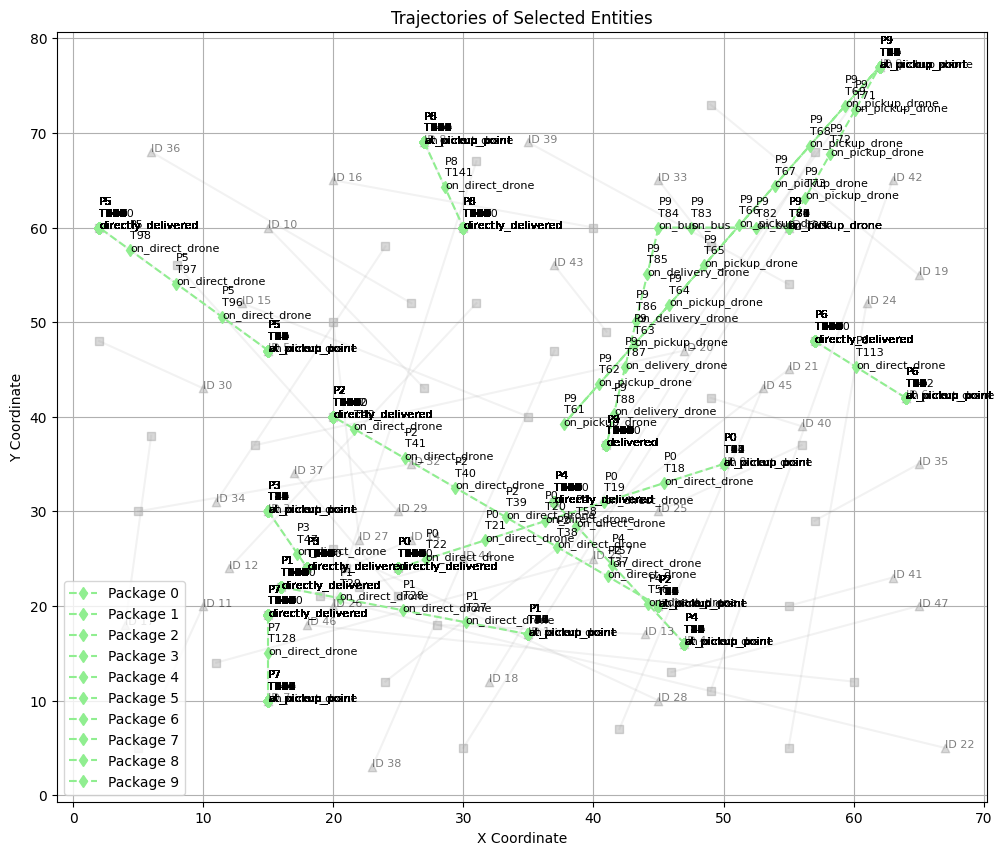

In [43]:
def plot_multiple_trajectories(simulation_records, package_records, drone_ids=None, bus_ids=None, package_ids=None):
    """
    绘制多个实体（无人机、巴士或包裹）的轨迹，并标注时间点。
    """
    # 转换数据为 DataFrame
    sim_df = pd.DataFrame(simulation_records)
    pkg_df = pd.DataFrame(package_records)
    
    # 创建绘图
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # 绘制所有任务的取送点
    for ind in sorted_tasks.index:
        ax.scatter(sorted_tasks.iloc[ind]['pickup_x'], sorted_tasks.iloc[ind]['pickup_y'], 
                  marker='^', c='grey', alpha=0.3)
        ax.scatter(sorted_tasks.iloc[ind]['delivery_x'], sorted_tasks.iloc[ind]['delivery_y'], 
                  marker='s', c='grey', alpha=0.3)
        ax.plot([sorted_tasks.iloc[ind]['pickup_x'], sorted_tasks.iloc[ind]['delivery_x']], 
                [sorted_tasks.iloc[ind]['pickup_y'], sorted_tasks.iloc[ind]['delivery_y']], 
                c='grey', alpha=0.1)
        ax.text(sorted_tasks.iloc[ind]['pickup_x'], sorted_tasks.iloc[ind]['pickup_y'], 
                f"ID {ind}", fontsize=8, color="black", alpha=0.5)

    # 绘制包裹轨迹
    if package_ids:
        for package_id in package_ids:
            package_df = pkg_df[pkg_df["package_id"] == package_id].copy()
            
            # 删除任何x或y为None/NaN的记录
            package_df = package_df.dropna(subset=['x', 'y'])
            
            if not package_df.empty:
                # 按时间排序
                package_df = package_df.sort_values('time')
                
                # 打印调试信息
                print(f"\nPackage {package_id} trajectory data:")
                print(package_df[['time', 'x', 'y', 'status']].to_string())
                
                # 绘制轨迹线（只在有效坐标之间）
                ax.plot(package_df["x"], package_df["y"], 
                       linestyle="--", marker="d", 
                       label=f"Package {package_id}", 
                       color="lightgreen")
                
                # 在每个点添加时间标注
                for _, row in package_df.iterrows():
                    ax.text(row["x"], row["y"], 
                           f"P{package_id}\nT{row['time']}\n{row['status']}", 
                           fontsize=8, color="black")
            else:
                print(f"No valid coordinate data found for Package ID {package_id}")

    # 绘制无人机轨迹
    if drone_ids:
        for drone_id in drone_ids:
            drone_df = sim_df[(sim_df["entity"] == "drone") & (sim_df["id"] == drone_id)]
            if not drone_df.empty:
                ax.plot(drone_df["x"], drone_df["y"], 
                       linestyle="-", marker="^", 
                       label=f"Drone {drone_id}", 
                       color="lightblue")
                
    # 绘制巴士轨迹
    if bus_ids:
        for bus_id in bus_ids:
            bus_df = sim_df[(sim_df["entity"] == "bus") & (sim_df["id"] == bus_id)]
            if not bus_df.empty:
                ax.plot(bus_df["x"], bus_df["y"], 
                       linestyle="-", marker="o", 
                       label=f"Bus {bus_id}", 
                       color="pink")

    # 设置图表样式
    ax.set_title("Trajectories of Selected Entities")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.grid(True)
    ax.legend()
    
    plt.show()

plot_multiple_trajectories(simulation_records, package_records, 
                         drone_ids=[    
                        ], 
                         bus_ids=[], 
                         package_ids=[ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## different station ranks 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import copy
import time

def run_simulation_with_ranks(pickup_rank, delivery_rank):
    """
    使用指定的站点排名配置运行一次完整模拟。
    
    参数:
    - pickup_rank: 取货站点排名
    - delivery_rank: 送货站点排名
    
    返回:
    - 分析结果
    """
    print(f"\n===============================================")
    print(f"开始运行模拟: pickup_rank={pickup_rank}, delivery_rank={delivery_rank}")
    print(f"===============================================")
    
    # 保存原始任务列表的拷贝，防止变量污染
    global task_list, tasks, packages, simulation_records, bus_records, package_records
    task_list_copy = copy.deepcopy(task_list)
    
    # 重置所有模拟变量
    tolerance = 10
    # 初始化统计信息
    task_statistics = []
    # 存储每个时间步的记录
    simulation_records = []
    bus_records = []
    package_records = []
    # 读取巴士站的x和y坐标并初始化巴士站
    bus_stations = [
        BusStation(row['x'], row['y'], row['line'])  # 假设 bus_stations_df 中有 'line' 列
        for index, row in bus_stations_df.iterrows()
    ]
    # 初始化模拟
    drone_fleet = DroneFleet()
    bus_lines = ['Line 1', 'Line 2']

    bus_system = BusSystem()
    bus_system.simulate(bus_lines, bus_stations_df)


    # 初始化任务和包裹
    tasks = task_list_copy
    packages = []
    for task in tasks:
        task['pickup_status'] = 'unassigned'
        task['delivery_status'] = 'unassigned'
        task['pickup_station_rank'] = pickup_rank
        task['delivery_station_rank'] = delivery_rank
        
        task['pickup_start_time'] = None
        task['pickup_complete_time'] = None
        task['delivery_start_time'] = None
        task['delivery_complete_time'] = None
        task['direct_start_time'] = None
        task['direct_complete_time'] = None
        
        package = Package(task['index'], task['index'])
        packages.append(package)
        task['package_id'] = task['index']
    
    # 设置模拟参数
    total_time = 1000
    current_time = 0
    task_index = 0
    
    # 站点映射
    station_mapping = {(station.x, station.y): idx for idx, station in enumerate(bus_stations)}
    
    # 运行模拟
    start_time = time.time()
    while current_time <= total_time:
        bus_system.simulate(bus_lines, bus_stations_df)
        
        # 处理队列
        drone_fleet.process_delivery_task_queue()
        drone_fleet.process_pickup_task_queue()
        drone_fleet.process_direct_task_queue()
        
        # 分配新任务
        while task_index < len(tasks) and tasks[task_index]['pickup_time'] <= current_time:
            task = tasks[task_index]
            if task['pickup_status'] == 'unassigned':
                # 计算运输距离
                bus_distance, drone_distance = calculate_transport_distance(
                    task['pickup_x'], task['pickup_y'], task['delivery_x'], task['delivery_y'],
                    bus_stations, bus_lines
                )

                # 选择运输方式
                if drone_distance - tolerance < bus_distance:
                    # 直接用无人机运输
                    success_pickup = drone_fleet.try_allocate_direct_transport(
                        task, task['pickup_x'], task['pickup_y'], 
                        task['delivery_x'], task['delivery_y']
                    )
                    if not success_pickup:
                        drone_fleet.add_direct_task_to_queue(
                            task, task['pickup_x'], task['pickup_y'],
                            task['delivery_x'], task['delivery_y']
                        )
                else:
                    # 使用巴士运输
                    best_line, min_distance, pickup_station, delivery_station = calculate_best_line_with_station_rank(
                        task['pickup_x'], task['pickup_y'], 
                        task['delivery_x'], task['delivery_y'], 
                        bus_stations, bus_lines,
                        pickup_rank, delivery_rank
                    )
                    
                    task['line'] = best_line
                    
                    # 分配取货任务
                    success_pickup = drone_fleet.try_allocate_pickup_task(
                        task, task['pickup_x'], task['pickup_y'], pickup_rank
                    )
                    if not success_pickup:
                        drone_fleet.add_pickup_task_to_queue(
                            task, task['pickup_x'], task['pickup_y'], pickup_rank
                        )
                    
                    # 分配送货任务
                    success_delivery = drone_fleet.try_allocate_delivery_task(
                        task, task['delivery_x'], task['delivery_y'], 
                        auto_create_drone=False, station_rank=delivery_rank
                    )
                    if not success_delivery:
                        drone_fleet.add_delivery_task_to_queue(
                            task, task['delivery_x'], task['delivery_y'], delivery_rank
                        )
            
            task_index += 1
        
        # 移动所有无人机
        drone_fleet.move_all_drones(current_time)
        bus_system.simulate(bus_lines, bus_stations_df)
        
        # 记录每个包裹的当前状态和位置
        for package in packages:
            task = get_task_by_id(package.task_id)
            if task is not None:
                if package.status == 'at_pickup_point':
                    x, y = task['pickup_x'], task['pickup_y']
                elif package.status == 'on_pickup_drone':
                    drone = next((d for d in drone_fleet.drones if d.current_task and d.current_task['package_id'] == package.package_id), None)
                    x, y = (drone.x, drone.y) if drone else (None, None)
                elif package.status == 'on_bus':
                    bus = next((b for b in bus_system.buses if b.current_package == package), None)
                    x, y = (bus.x, bus.y) if bus else (None, None)
                elif package.status == 'on_delivery_drone':
                    drone = next((d for d in drone_fleet.drones if d.current_task and d.current_task['package_id'] == package.package_id), None)
                    x, y = (drone.x, drone.y) if drone else (None, None)
                elif package.status == 'delivered':
                    x, y = task['delivery_x'], task['delivery_y']
                elif package.status == 'on_direct_drone':
                    drone = next((d for d in drone_fleet.drones if d.current_task and d.current_task['package_id'] == package.package_id), None)
                    x, y = (drone.x, drone.y) if drone else (None, None)
                elif package.status == 'directly_delivered':
                    x, y = task['delivery_x'], task['delivery_y']
                else:
                    x, y = None, None
                
                # 记录包裹状态
                package_records.append({
                    "time": current_time,
                    "package_id": package.package_id,
                    "task_id": package.task_id,
                    "status": package.status,
                    "x": x,
                    "y": y
                })
        
        # 记录无人机状态
        for drone in drone_fleet.drones:
            simulation_records.append({
                "time": current_time,
                "entity": "drone",
                "id": drone.drone_id,
                "x": drone.x,
                "y": drone.y,
                "status": drone.status
            })
        
        # 记录巴士状态
        for bus in bus_system.buses:
            simulation_records.append({
                "time": current_time,
                "entity": "bus",
                "id": bus.bus_id,
                "x": bus.x,
                "y": bus.y,
                "status": bus.status,
                "direction": bus.direction
            })
            
            # 记录巴士站点信息
            current_station = station_mapping.get((bus.x, bus.y), None)
            if current_station is not None:
                station_index = next(
                    (station['station_index'] for station in bus.route if station['x'] == bus.x and station['y'] == bus.y),
                    None
                )
                line = bus.route[0]['line'] if bus.route else None
                
                bus_records.append({
                    "time": current_time,
                    "entity": "bus",
                    "id": bus.bus_id,
                    "station": current_station,
                    "station_index": station_index,
                    "line": line,
                    "has_package": bus.current_package is not None
                })
        
        # 处理巴士交接包裹
        for drone in drone_fleet.drones:
            if (
                drone.status == 'waiting_at_bus_station_for_pickup_bus' and 
                drone.current_task is not None and 
                drone.current_task['pickup_status'] == 'waiting_for_bus'
            ):
                # 取货逻辑
                current_line = drone.current_task['line']
                
                intersecting_lines = [
                    line for line in bus_lines
                    if any(station for station in bus_stations if station.line == line and station.x == drone.x and station.y == drone.y)
                ]
                
                if len(intersecting_lines) > 1 and current_line not in intersecting_lines:
                    print(f"Error: Drone {drone.drone_id} is at an intersection but not waiting for the correct line.")
                    continue
                
                nearest_delivery_station = find_nearest_bus_station(
                    drone.current_task['delivery_x'], 
                    drone.current_task['delivery_y'], 
                    bus_stations, 
                    current_line
                )

                bus = bus_system.check_buses_at_station_for_pickup(
                    drone.x, 
                    drone.y, 
                    line=current_line, 
                    delivery_station=(nearest_delivery_station.x, nearest_delivery_station.y)
                )
                
                if bus and bus.can_pickup_package():
                    package = get_package_by_id(drone.current_task['package_id'])
                    if package:
                        bus.load_package(package)
                        package.bus_id = bus.bus_id
                        package.update_status('on_bus')
                        drone.current_task['pickup_status'] = 'completed'
                        # 记录取货完成时间
                        drone.current_task['pickup_complete_time'] = current_time
                        drone.current_task = None
                        drone.status = 'idle'
                        drone.pickup_tasks_completed += 1
            
            elif drone.status == 'waiting_at_bus_station_for_delivery':
                # 送货逻辑
                package = get_package_by_id(drone.current_task['package_id'])
                if package:
                    bus = bus_system.check_buses_at_station_for_delivery(drone.x, drone.y, package.bus_id)
                    
                    if bus and bus.current_package:
                        package = bus.unload_package()
                        package.update_status('on_delivery_drone')
                        task = get_task_by_id(package.task_id)
                        if task is not None:
                            # 记录送货开始时间
                            task['delivery_start_time'] = current_time
                            drone.assign_delivery_task(task, task['delivery_x'], task['delivery_y'], task['line'])
                            drone.status = 'moving_to_delivery'
                        else:
                            print(f"错误: 未找到 package_id 为 {package.package_id} 的任务")
        
        # 增加模拟时间
        current_time += 1
        
        # 进度打印（每100个时间单位）
        if current_time % 100 == 0:
            completion_percentage = (current_time / total_time) * 100
            elapsed_time = time.time() - start_time
            print(f"模拟进度: {current_time}/{total_time} ({completion_percentage:.1f}%) - 运行时间: {elapsed_time:.1f}秒")
    
    # 模拟完成
    elapsed_time = time.time() - start_time
    print(f"模拟完成! 总用时: {elapsed_time:.1f}秒")
    
    # 分析结果
    result = analyze_task_completion_times(pickup_rank, delivery_rank)
    return result

def analyze_task_completion_times(pickup_rank, delivery_rank):
    """Analyze task completion times and drone flight times"""
    total_tasks = len(tasks)
    completed_delivery = 0
    completed_direct = 0
    
    pickup_times = []  # Pickup times
    delivery_times = [] # Delivery times
    direct_times = []   # Direct transportation times
    total_times = []    # Total task times
    
    for task in tasks:
        # Check if task was completed successfully
        if task['pickup_complete_time'] is not None and task['pickup_start_time'] is not None:
            pickup_time = task['pickup_complete_time'] - task['pickup_start_time']
            pickup_times.append(pickup_time)
        
        if task['delivery_complete_time'] is not None and task['delivery_start_time'] is not None:
            delivery_time = task['delivery_complete_time'] - task['delivery_start_time']
            delivery_times.append(delivery_time)
            completed_delivery += 1
            
            # Calculate total task time (from task generation to delivery)
            total_time = task['delivery_complete_time'] - task['pickup_time']
            total_times.append(total_time)
        
        if task['direct_complete_time'] is not None and task['direct_start_time'] is not None:
            direct_time = task['direct_complete_time'] - task['direct_start_time']
            direct_times.append(direct_time)
            completed_direct += 1
            
            # Calculate total task time (from task generation to delivery)
            total_time = task['direct_complete_time'] - task['pickup_time']
            total_times.append(total_time)
    
    # Calculate statistics
    avg_pickup_time = sum(pickup_times) / len(pickup_times) if pickup_times else 0
    avg_delivery_time = sum(delivery_times) / len(delivery_times) if delivery_times else 0
    avg_direct_time = sum(direct_times) / len(direct_times) if direct_times else 0
    avg_total_time = sum(total_times) / len(total_times) if total_times else 0
    
    # Calculate drone flight times
    drone_ids = set(r['id'] for r in simulation_records if r['entity'] == 'drone')
    drone_flight_records = {}
    
    for drone_id in drone_ids:
        active_records = [r for r in simulation_records if r['entity'] == 'drone' and r['id'] == drone_id and r['status'] != 'idle']
        drone_flight_records[drone_id] = len(active_records)
    
    total_flight_time = sum(drone_flight_records.values())
    avg_flight_time = total_flight_time / len(drone_flight_records) if drone_flight_records else 0
    
    # Print results
    print(f"\n===== Task Completion Time Analysis (pickup_rank={pickup_rank}, delivery_rank={delivery_rank}) =====")
    print(f"Total tasks: {total_tasks}")
    print(f"Completed regular delivery tasks: {completed_delivery}")
    print(f"Completed direct transportation tasks: {completed_direct}")
    print(f"Total completion rate: {(completed_delivery + completed_direct) / total_tasks * 100:.2f}%")
    
    print(f"\nAverage pickup time: {avg_pickup_time:.2f} time units")
    print(f"Average delivery time: {avg_delivery_time:.2f} time units")
    print(f"Average direct transportation time: {avg_direct_time:.2f} time units")
    print(f"Average total task time: {avg_total_time:.2f} time units")
    
    print(f"\nTotal drone flight time: {total_flight_time} time units")
    print(f"Average flight time per drone: {avg_flight_time:.2f} time units")
    print(f"Number of drones: {len(drone_flight_records)}")
    
    # Return analysis results dictionary
    return {
        'pickup_rank': pickup_rank,
        'delivery_rank': delivery_rank,
        'total_tasks': total_tasks,
        'completed_delivery': completed_delivery,
        'completed_direct': completed_direct,
        'completion_rate': (completed_delivery + completed_direct) / total_tasks,
        'avg_pickup_time': avg_pickup_time,
        'avg_delivery_time': avg_delivery_time,
        'avg_direct_time': avg_direct_time,
        'avg_total_time': avg_total_time,
        'total_flight_time': total_flight_time,
        'avg_flight_time': avg_flight_time,
        'drone_count': len(drone_flight_records)
    }

def compare_all_configurations():
    """
    Run simulations with multiple different configurations and compare results.
    """
    configurations = [
        (0, 0),  # Baseline configuration: nearest pickup station and nearest delivery station
        (1, 0),  # Second nearest pickup station and nearest delivery station
        (0, 1),  # Nearest pickup station and second nearest delivery station
        (1, 1),  # Second nearest pickup station and second nearest delivery station
        (2, 0),  # Third nearest pickup station and nearest delivery station
        (0, 2),  # Nearest pickup station and third nearest delivery station
        (2, 1),  # Third nearest pickup station and second nearest delivery station
        (1, 2),  # Second nearest pickup station and third nearest delivery station
        (2, 2)   # Third nearest pickup station and third nearest delivery station
    ]
    
    results = []
    
    for pickup_rank, delivery_rank in configurations:
        result = run_simulation_with_ranks(pickup_rank, delivery_rank)
        results.append(result)
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    
    # Save to CSV file
    results_df.to_csv('station_rank_comparison_results.csv', index=False)
    print("Results saved to station_rank_comparison_results.csv")
    
    # Create comparison charts
    create_comparison_charts(results)
    
    return results

def create_comparison_charts(results):
    """
    Create charts comparing different configurations.
    
    Parameters:
    - results: List containing analysis results for each configuration
    """
    # Create configuration labels
    config_labels = [f"P{r['pickup_rank']},D{r['delivery_rank']}" for r in results]
    
    # Set up charts
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Average task completion time
    axs[0, 0].bar(config_labels, [r['avg_total_time'] for r in results], color='skyblue')
    axs[0, 0].set_title('Average Task Completion Time', fontsize=14)
    axs[0, 0].set_ylabel('Time Units', fontsize=12)
    axs[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
    
    # 2. Total drone flight time
    axs[0, 1].bar(config_labels, [r['total_flight_time'] for r in results], color='orange')
    axs[0, 1].set_title('Total Drone Flight Time', fontsize=14)
    axs[0, 1].set_ylabel('Time Units', fontsize=12)
    axs[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
    
    # 3. Task completion rate
    completion_rates = [r['completion_rate'] * 100 for r in results]
    axs[1, 0].bar(config_labels, completion_rates, color='green')
    axs[1, 0].set_title('Task Completion Rate', fontsize=14)
    axs[1, 0].set_ylabel('Percentage (%)', fontsize=12)
    axs[1, 0].set_ylim([0, 100])
    axs[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
    
    # 4. Number of drones
    axs[1, 1].bar(config_labels, [r['drone_count'] for r in results], color='purple')
    axs[1, 1].set_title('Number of Drones', fontsize=14)
    axs[1, 1].set_ylabel('Count', fontsize=12)
    axs[1, 1].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Set chart title and layout
    plt.suptitle('Performance Comparison of Different Station Ranking Configurations', fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Save chart
    plt.savefig('station_rank_comparison.png', dpi=300, bbox_inches='tight')
    print("Comparison chart saved as station_rank_comparison.png")

# 调用此函数运行所有配置的比较
results = compare_all_configurations()

## Different Tolerance

In [ ]:
import pandas as pd
import numpy as np

def run_simulation(task_subset, tolerance_value):
    # 重置所有全局变量
    global task_index, current_time, packages, simulation_records, bus_records, package_records
    task_index = 0
    current_time = 0
    simulation_records = []
    bus_records = []
    package_records = []
    
    # 初始化系统
    drone_fleet = DroneFleet()
    bus_system = BusSystem()
    bus_system.simulate(bus_lines, bus_stations_df)
    
    # 初始化任务和包裹
    tasks = task_subset.copy()  # 使用提供的任务子集
    packages = []
    
    for task in tasks:
        task['pickup_status'] = 'unassigned'
        task['delivery_status'] = 'unassigned'
        package = Package(task['index'], task['index'])
        packages.append(package)
        task['package_id'] = task['index']
    
    # 运行模拟
    while current_time <= total_time:

        bus_system.simulate(bus_lines, bus_stations_df)


        # 定期检查并处理等待队列中的任务
        drone_fleet.process_delivery_task_queue()
        drone_fleet.process_pickup_task_queue()
        drone_fleet.process_direct_task_queue()
        while task_index < len(tasks) and tasks[task_index]['pickup_time'] <= current_time:
            task = tasks[task_index]
            if task['pickup_status'] == 'unassigned':
                #
                # 计算运输距离
                bus_distance, drone_distance = calculate_transport_distance(
                    task['pickup_x'], task['pickup_y'], task['delivery_x'], task['delivery_y'],
                    bus_stations, bus_lines
                )
                if task['index'] == 24:  # 或使用 task['package_id'] == 24，取决于你的实际标识符
                    # ID 24 强制使用直接配送
                    success_pickup = drone_fleet.try_allocate_direct_transport(
                        task, 
                        task['pickup_x'], 
                        task['pickup_y'], 
                        task['delivery_x'], 
                        task['delivery_y']
                    )
                    print(f"\nProcessing Task 24 at time {current_time}:")
                    print(f"Current task index: {task_index}")
                    print(f"Pickup location: ({task['pickup_x']}, {task['pickup_y']})")
                    print(f"Delivery location: ({task['delivery_x']}, {task['delivery_y']})")
                    
                    if not success_pickup:
                        drone_fleet.add_direct_task_to_queue(
                            task,
                            task['pickup_x'],
                            task['pickup_y'],
                            task['delivery_x'],
                            task['delivery_y']
                        )
                # 选择运输方式
                elif drone_distance - tolerance < bus_distance:
                    # 直接用无人机运输
                    success_pickup = drone_fleet.try_allocate_direct_transport(task, task['pickup_x'], task['pickup_y'], task['delivery_x'], task['delivery_y'])
                    if not success_pickup:
                        drone_fleet.add_direct_task_to_queue(task, task['pickup_x'], task['pickup_y'],task['delivery_x'], task['delivery_y'],)
                else:
                    # 使用巴士运输（原有逻辑）
                    best_line, min_distance = calculate_best_line(
                        task['pickup_x'], task['pickup_y'], task['delivery_x'], task['delivery_y'], 
                        bus_stations, bus_lines
                    )
                    task['line'] = best_line

                    success_pickup = drone_fleet.try_allocate_pickup_task(task, task['pickup_x'], task['pickup_y'])
                    if not success_pickup:
                        drone_fleet.add_pickup_task_to_queue(task, task['pickup_x'], task['pickup_y'])

                    success_delivery = drone_fleet.try_allocate_delivery_task(task, task['delivery_x'], task['delivery_y'], auto_create_drone=False)
                    if not success_delivery:
                        drone_fleet.add_delivery_task_to_queue(task, task['delivery_x'], task['delivery_y'])
                    
                    # 记录取货时间，用于延迟分配送货任务
                    # task['pickup_assignment_time'] = current_time

            task_index += 1


        drone_fleet.move_all_drones()
        bus_system.simulate(bus_lines, bus_stations_df)


        


        # 记录每个 package 的当前状态和位置
        # 更新包裹状态并记录
        for package in packages:
            task = get_task_by_id(package.task_id)  # Find the associated task
            if package.status == 'at_pickup_point':
                x, y = task['pickup_x'], task['pickup_y']
            elif package.status == 'on_pickup_drone':
                drone = next((drone for drone in drone_fleet.drones if drone.current_task and drone.current_task['package_id'] == package.package_id), None)
                x, y = (drone.x, drone.y) if drone else (None, None)
            elif package.status == 'on_bus':
                bus = next((bus for bus in bus_system.buses if bus.current_package == package), None) # 遍历 bus_system.buses 中的所有公交车，查找当前携带该包裹 (package.package_id) 的公交车。
                x, y = (bus.x, bus.y) if bus else (None, None)
            elif package.status == 'on_delivery_drone':
                drone = next((drone for drone in drone_fleet.drones if drone.current_task and drone.current_task['package_id'] == package.package_id), None)
                x, y = (drone.x, drone.y) if drone else (None, None)
            elif package.status == 'delivered':
                x, y = task['delivery_x'], task['delivery_y']
            elif package.status == 'on_direct_drone':
                drone = next((drone for drone in drone_fleet.drones if drone.current_task and drone.current_task['package_id'] == package.package_id), None)
                x, y = (drone.x, drone.y) if drone else (None, None)
            elif package.status == 'directly_delivered':
                x, y = task['delivery_x'], task['delivery_y']

            # 记录包裹状态
            package_records.append({
                "time": current_time,
                "package_id": package.package_id,
                "task_id": package.task_id,
                "status": package.status,
                "x": x,
                "y": y
            })
        # 在主循环中打印队列
        # print(f"Time {current_time}: Delivery Task Queue")
        # for task in drone_fleet.delivery_task_queue:
        #     print(f"Task {task['pickup_task']} - Pickup: {task['pickup_status']}, Delivery: {task['delivery_status']}")

        for drone in drone_fleet.drones:
            simulation_records.append({
                "time": current_time,
                "entity": "drone",
                "id": drone.drone_id,
                "x": drone.x,
                "y": drone.y,
                "status": drone.status
            })

        for bus in bus_system.buses:
            simulation_records.append({
                "time": current_time,
                "entity": "bus",
                "id": bus.bus_id,
                "x": bus.x,
                "y": bus.y,
                "status": bus.status,
                "direction": bus.direction
            })

        for bus in bus_system.buses:
            # 获取当前站点编号
            current_station = station_mapping.get((bus.x, bus.y), None)
            if current_station is not None:
                # 获取对应的 station_index 和线路信息
                station_index = next(
                    (station['station_index'] for station in bus.route if station['x'] == bus.x and station['y'] == bus.y),
                    None
                )
                line = bus.route[0]['line'] if bus.route else None  # 假设所有站点的 line 一致

                # 记录数据
                bus_records.append({
                    "time": current_time,
                    "entity": "bus",
                    "id": bus.bus_id,
                    "station": current_station,       # 站点名称或编号
                    "station_index": station_index,  # 站点索引
                    "line": line,                    # 所属线路
                    "has_package": bus.current_package is not None  # 判断是否携带包裹
                })


        for drone in drone_fleet.drones:
            if (
                drone.status == 'waiting_at_bus_station_for_pickup_bus' and 
                drone.current_task is not None and 
                drone.current_task['pickup_status'] == 'waiting_for_bus'
            ):
                # 确定当前任务所在的线路
                current_line = drone.current_task['line']
                print(drone.current_task['package_id'])
                # print(current_line+'芜湖起飞')

                
                # 检查当前位置是否为两条线路的交界处
                intersecting_lines = [
                    line for line in bus_lines
                    if any(station for station in bus_stations if station.line == line and station.x == drone.x and station.y == drone.y)
                ]
                
                # 如果是交界处，确保无人机在等当前线路的大巴
                if len(intersecting_lines) > 1 and current_line not in intersecting_lines:
                    print(f"Error: Drone {drone.drone_id} is at an intersection but not waiting for the correct line.")
                    continue
                
                nearest_delivery_station = find_nearest_bus_station(
                    drone.current_task['delivery_x'], 
                    drone.current_task['delivery_y'], 
                    bus_stations, 
                    current_line
                )

                bus = bus_system.check_buses_at_station_for_pickup(
                    drone.x, 
                    drone.y, 
                    line=current_line, 
                    delivery_station=(nearest_delivery_station.x, nearest_delivery_station.y)
    )
                
                if bus and bus.can_pickup_package():
                    package = get_package_by_id(drone.current_task['package_id'])
                    bus.load_package(package)
                    package.bus_id = bus.bus_id  # Associate the package with the bus
                    package.update_status('on_bus')
                    drone.current_task['pickup_status'] = 'completed'
                    drone.current_task = None
                    drone.status = 'idle'
                    drone.pickup_tasks_completed += 1
                    # if package.package_id == 11:
                    #     print(f"芜湖起飞Debug Package 11: Time {current_time}, Status: {package.status}, Bus: {package.bus_id}")
                    #     print(f"不会吧 这也不显示吗Package 11 is assigned to line: {task['line']}")
                

            elif drone.status == 'waiting_at_bus_station_for_delivery':
                # Modify this line to use the correct function
                package = get_package_by_id(drone.current_task['package_id'])  # Ensure package is retrieved first
                bus = bus_system.check_buses_at_station_for_delivery(drone.x, drone.y, package.bus_id)

                if package.package_id == 11:
                    print(f"Debug Package 11: Time {current_time}, Status: {package.status}, Bus: {package.bus_id}")
                
                if bus and bus.current_package:
                    package = bus.unload_package()
                    # print(f"Unloaded package ID: {package.package_id} 哈哈哈哈哈哈")  # 调试输出

                    package.update_status('on_delivery_drone')
                    task = get_task_by_id(package.task_id)
                    if task is not None:
                        drone.assign_delivery_task(task, task['delivery_x'], task['delivery_y'],task['line'] )
                        drone.status = 'moving_to_delivery'
                    else:
                        print(f"错误: 未找到 package_id 为 {package.package_id} 的任务")
                # else:
                #     print(f"错误: 未找到 package_id 为 {package.package_id} 的包裹或对应的巴士")

        current_time += 1
        

    
    # 统计结果
    direct_transport_count = 0
    bus_transport_count = 0
    
    for package in packages:
        if package.status in ['directly_delivered']:
            direct_transport_count += 1
        elif package.status in ['delivered']:
            bus_transport_count += 1
    active_drones = len([drone for drone in drone_fleet.drones])
    
    return {
        'num_tasks': len(task_subset),
        'Penalty': tolerance_value,
        'direct_transport': direct_transport_count,
        'bus_transport': bus_transport_count,
        'num_drones': active_drones 
    }

# 准备结果DataFrame
results = []

# 不同任务数量的实验
task_counts = [5, 10, 15, 20, 25, 30, 35, 40, 45, len(task_list)]
tolerance_values = [0, 5, 10, 15, 20, 25]

for num_tasks in task_counts:
    task_subset = task_list[:num_tasks]  # 取前n个任务
    
    for tolerance in tolerance_values:
        result = run_simulation(task_subset, tolerance)
        results.append(result)

# 创建结果DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# 可以保存结果
results_df.to_csv('simulation_results.csv', index=False)

In [ ]:
results_df

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



results_df['bus_transport_ratio'] = results_df['bus_transport'] / results_df['num_tasks']

plt.style.use('default')
sns.set_palette("husl")
plt.figure(figsize=(12, 8))

# 为每个penalty值创建一个子数据集并绘制趋势线
for penalty in results_df['Penalty'].unique():
    mask = results_df['Penalty'] == penalty
    data = results_df[mask]
    
    plt.scatter(data['num_tasks'], data['bus_transport_ratio'],
               label=f'Penalty={penalty}', alpha=0.7, s=100)
    
    # 添加趋势线
    z = np.polyfit(data['num_tasks'], data['bus_transport_ratio'], 2)
    p = np.poly1d(z)
    x_trend = np.linspace(data['num_tasks'].min(), data['num_tasks'].max(), 100)
    plt.plot(x_trend, p(x_trend), '--', alpha=0.7)

plt.xlabel('Number of Tasks', fontsize=15)
plt.ylabel('Bus Transport Ratio', fontsize=15)
plt.title('Bus Transport Ratio vs Number of Tasks for Different Penalty Values', fontsize=15)
plt.legend(prop={'size': 15})
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))

# 自定义颜色方案，使用高对比度的颜色
colors = ['#FF0000', '#00FF00', '#0000FF', '#FFD700', '#FF1493', '#00FFFF']

sns.swarmplot(data=results_df, x='num_tasks', y='num_drones', 
              hue='Penalty', size=8, 
              palette=colors)

plt.xlabel('Number of Tasks', fontsize=15)
plt.ylabel('Number of Drones', fontsize=15)
plt.title('Number of Drones vs Number of Tasks for Different Penalty Values', fontsize=15)
plt.legend(prop={'size': 15}, title='Penalty')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# 假设您的 package_simulation_df 已经加载为 DataFrame

# 定义函数来计算总运输时间和运输方式
def calculate_task_transport_times(package_df):
    # 按 package_id 分组
    transport_data = []
    grouped = package_df.groupby("task_id")
    
    for task_id, group in grouped:
        # 确定 pickup 和 delivery 的时间
        group = group.sort_values(by="time")
        pickup_time = group[group["status"].str.contains("on_pickup_drone|on_direct_drone")]["time"].min()
        delivery_time = group[group["status"].str.contains("delivered|directly_delivered")]["time"].min()
        
        # 确保 pickup_time 和 delivery_time 存在
        if pd.notna(pickup_time) and pd.notna(delivery_time):
            total_time = delivery_time - pickup_time
            
            # 确定运输方式
            if group["status"].str.contains("direct").any():
                transport_method = "direct_transport"
            else:
                transport_method = "transported_with_drone_bus"
            
            # 记录信息
            transport_data.append({
                "task_id": task_id,
                "pickup_time": pickup_time,
                "delivery_time": delivery_time,
                "total_time": total_time,
                "transport_method": transport_method
            })
    
    # 转换为 DataFrame
    return pd.DataFrame(transport_data)

task_transport_df = calculate_task_transport_times(package_simulation_df)
task_transport_df

In [ ]:
# # 假设 task_transport_df 和 task_transport_df_mix 已经加载为 DataFrame

# 重命名 task_transport_df 的 total_time 列为 direct_time
task_transport_df = task_transport_df.rename(columns={'total_time': 'direct_time'})

# 合并两个 DataFrame
# 假设两者均有相同的 task_id
merged_df = pd.merge(task_transport_df_mix, task_transport_df[['task_id', 'direct_time']], 
                     on='task_id', how='left')

# 调整列顺序，将 direct_time 放在 total_time 的右侧
cols = list(merged_df.columns)
total_time_index = cols.index('total_time')
cols = cols[:total_time_index + 1] + ['direct_time'] + cols[total_time_index + 1:-1]
merged_df = merged_df[cols]

merged_df.to_csv('tolerance_10_total_direct_time.csv')
merged_df = pd.read_csv('tolerance_10_total_direct_time.csv')
merged_df

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置风格
# plt.style.use('seaborn')
sns.set_palette("husl")

# 颜色定义
color1 = '#3498db'  # 蓝色
color2 = 'orange'  # 红色

plt.figure(figsize=(12, 10))
x = range(len(filtered_df))

# 绘制柱状图
plt.bar(x, filtered_df['total_time'], width=0.4, 
        label='Total Time (Drone + Bus)', 
        align='center', 
        color=color1,
        alpha=0.8)
plt.bar([i + 0.4 for i in x], filtered_df['direct_time'], 
        width=0.4, 
        label='Direct Time', 
        align='center',
        color=color2,
        alpha=0.8)

# 添加标签
plt.xlabel('Task Index (Filtered)', fontsize=15)
plt.ylabel('Time (units)', fontsize=15)
plt.title('Comparison of Total Time vs Direct Time', fontsize=15)
plt.xticks([i + 0.2 for i in x], filtered_df['task_id'], rotation=90, fontsize=15)
plt.legend(fontsize=15, loc='upper right')

# 添加网格
plt.grid(axis='y', linestyle='--', alpha=0.3)

# 设置背景
plt.gca().set_facecolor('#f8f9fa')
plt.gcf().set_facecolor('white')

plt.tight_layout()
plt.show()

In [ ]:
# 筛选 pickup_status 或 delivery_status 不为 'completed' 的任务
unfinished_tasks = [
    task for task in tasks 
    if task['pickup_status'] != 'completed' or task['delivery_status'] != 'completed'
]

# 打印未完成任务的信息
print(f"Total unfinished tasks: {len(unfinished_tasks)}")
for task in unfinished_tasks:
    print(task['index'])

## Static movement

In [ ]:
import matplotlib.pyplot as plt

def plot_multiple_trajectories(simulation_records, package_records, drone_ids=None, bus_ids=None, package_ids=None):
    """
    绘制多个实体（无人机、巴士或包裹）的轨迹，并标注时间点。
    参数：
    - simulation_records: 模拟数据记录（包含无人机和巴士）
    - package_records: 包裹数据记录
    - drone_ids: 要绘制的无人机 ID 列表
    - bus_ids: 要绘制的巴士 ID 列表
    - package_ids: 要绘制的包裹 ID 列表
    """
    # 转换数据为 DataFrame
    sim_df = pd.DataFrame(simulation_records)
    pkg_df = pd.DataFrame(package_records)

    # 创建绘图
    fig, ax = plt.subplots(figsize=(12, 10))

    # plot pick up (triangle) and delivery (square) for each pair and label
    for ind in sorted_tasks.index:
        ax.scatter(sorted_tasks.iloc[ind]['pickup_x'], sorted_tasks.iloc[ind]['pickup_y'], marker='^', c='grey')
        ax.scatter(sorted_tasks.iloc[ind]['delivery_x'], sorted_tasks.iloc[ind]['delivery_y'], marker='s', c='grey')
        ax.plot(sorted_tasks.iloc[ind][['pickup_x', 'delivery_x']], 
                sorted_tasks.iloc[ind][['pickup_y', 'delivery_y']], c='grey')
        ax.text(sorted_tasks.iloc[ind]['pickup_x'], sorted_tasks.iloc[ind]['pickup_y'], 
                f"ID {ind}", fontsize=8, color="black", ha="right", va="bottom")

    # 绘制无人机轨迹
    if drone_ids:
        for drone_id in drone_ids:
            drone_df = sim_df[(sim_df["entity"] == "drone") & (sim_df["id"] == drone_id)]
            if not drone_df.empty:
                ax.plot(drone_df["x"], drone_df["y"], linestyle="-", marker="^", 
                       label=f"Drone {drone_id}", color="lightblue")
                for _, row in drone_df.iterrows():
                    ax.text(row["x"], row["y"], str(row["time"]), 
                           fontsize=8, color="black", ha="right", va="bottom")
            else:
                print(f"No data found for Drone ID {drone_id}.")

    # 绘制巴士轨迹
    if bus_ids:
        for bus_id in bus_ids:
            bus_df = sim_df[(sim_df["entity"] == "bus") & (sim_df["id"] == bus_id)]
            if not bus_df.empty:
                ax.plot(bus_df["x"], bus_df["y"], linestyle="-", marker="o", 
                       label=f"Bus {bus_id}", color="pink")
            else:
                print(f"No data found for Bus ID {bus_id}.")

    # 绘制包裹轨迹
    if package_ids:
        for package_id in package_ids:
            package_df = pkg_df[pkg_df["package_id"] == package_id]
            if not package_df.empty:
                # 绘制轨迹线
                ax.plot(package_df["x"], package_df["y"], linestyle="--", marker="d", 
                       label=f"Package {package_id}", color="lightgreen")
                
                # 标注每个时间点的位置、Package ID和状态
                for _, row in package_df.iterrows():
                    status_abbr = {
                        'at_pickup_point': 'P',
                        'on_pickup_drone': 'PD',
                        'on_bus': 'B',
                        'on_delivery_drone': 'DD',
                        'on_direct_delivery_drone': 'DDD',  # 新增状态缩写
                        'delivered': 'D'
                    }.get(row['status'], '?')
                    
                    ax.text(row["x"], row["y"], 
                           f"ID {package_id}\nT {row['time']}\n{status_abbr}", 
                           fontsize=8, color="black", ha="right", va="bottom")
            else:
                print(f"No data found for Package ID {package_id}.")

    # 设置图表样式
    ax.set_title("Trajectories of Selected Entities")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.grid(True)
    ax.legend()
    plt.show()

# 示例调用
drone_ids = []
bus_ids = [1]
package_ids = [35]

# 绘制轨迹
plot_multiple_trajectories(simulation_records, package_records, 
                         drone_ids=drone_ids, bus_ids=bus_ids, package_ids=package_ids)

## Bus plot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def preprocess_disjoint_lines(df, x_column, y_column, max_gap):
    """
    对数据进行预处理，在 x 值差距超过 max_gap 的地方插入 np.nan，使线条断开。
    
    参数：
    - df: 输入 DataFrame，包含 x 和 y 数据
    - x_column: x 轴列名（例如 'time'）
    - y_column: y 轴列名（例如 'station_index'）
    - max_gap: x 值的最大允许差距
    
    返回：
    - x_processed, y_processed: 处理后的 x 和 y 列表
    """
    df_sorted = df.sort_values(by=x_column)
    x_processed = []
    y_processed = []

    for i in range(len(df_sorted)):
        if i > 0 and (df_sorted.iloc[i][x_column] - df_sorted.iloc[i - 1][x_column]) > max_gap:
            # 插入断点
            x_processed.append(np.nan)
            y_processed.append(np.nan)
        x_processed.append(df_sorted.iloc[i][x_column])
        y_processed.append(df_sorted.iloc[i][y_column])

    return x_processed, y_processed


def plot_bus_movements_by_line(simulation_df, num_stations, line1_buses, line2_buses):
    """
    分别绘制 Line 1 和 Line 2 的公交车在不同时间点的移动轨迹。
    - 实线表示有包裹
    - 虚线表示无包裹
    - 同一辆公交车保持相同颜色
    
    参数：
    - simulation_df: 包含公交车移动数据的 DataFrame
    - num_stations: 总站点数
    - line1_buses: Line 1 的公交车 ID 列表
    - line2_buses: Line 2 的公交车 ID 列表
    """
    max_gap = 10  # 时间差距的最大值

    # 绘制 Line 1
    plt.figure(figsize=(18, 8))
    plt.title("Bus Movement for Line 1", fontsize=14)
    color_map = {bus_id: plt.cm.tab10(i % 10) for i, bus_id in enumerate(line1_buses)}
    for bus_id in line1_buses:
        bus_data = simulation_df[simulation_df['id'] == bus_id]

        # 分离有包裹和无包裹的数据
        with_package = bus_data[bus_data['has_package']]
        without_package = bus_data[~bus_data['has_package']]

        # 预处理无包裹数据（虚线）
        time_without_package, station_without_package = preprocess_disjoint_lines(
            without_package, 'time', 'station_index', max_gap
        )
        plt.plot(
            time_without_package,
            station_without_package,
            label=f'Bus {bus_id} (no package)',
            linestyle='--',
            color=color_map[bus_id],
            marker='o',
            markersize=4,
            alpha=0.8,
            linewidth=1
        )

        # 预处理有包裹数据（实线加粗）
        time_with_package, station_with_package = preprocess_disjoint_lines(
            with_package, 'time', 'station_index', max_gap
        )
        plt.plot(
            time_with_package,
            station_with_package,
            label=f'Bus {bus_id} (with package)',
            linestyle='-',
            color=color_map[bus_id],
            marker='o',
            markersize=4,
            alpha=0.8,
            linewidth=2
        )

    # 设置图表样式
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Station Index", fontsize=12)
    plt.xticks(range(0, simulation_df['time'].max() + 1, 20), fontsize=10)
    plt.yticks(range(0, num_stations + 1), fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5, fontsize=8, frameon=False)
    plt.tight_layout()
    plt.show()

    # 绘制 Line 2
    plt.figure(figsize=(18, 8))
    plt.title("Bus Movement for Line 2", fontsize=14)
    color_map = {bus_id: plt.cm.tab10(i % 10) for i, bus_id in enumerate(line2_buses)}
    for bus_id in line2_buses:
        bus_data = simulation_df[simulation_df['id'] == bus_id]

        # 分离有包裹和无包裹的数据
        with_package = bus_data[bus_data['has_package']]
        without_package = bus_data[~bus_data['has_package']]

        # 预处理无包裹数据（虚线）
        time_without_package, station_without_package = preprocess_disjoint_lines(
            without_package, 'time', 'station_index', max_gap
        )
        plt.plot(
            time_without_package,
            station_without_package,
            label=f'Bus {bus_id} (no package)',
            linestyle='--',
            color=color_map[bus_id],
            marker='o',
            markersize=4,
            alpha=0.8,
            linewidth=1
        )

        # 预处理有包裹数据（实线加粗）
        time_with_package, station_with_package = preprocess_disjoint_lines(
            with_package, 'time', 'station_index', max_gap
        )
        plt.plot(
            time_with_package,
            station_with_package,
            label=f'Bus {bus_id} (with package)',
            linestyle='-',
            color=color_map[bus_id],
            marker='o',
            markersize=4,
            alpha=0.8,
            linewidth=2
        )

    # 设置图表样式
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Station Index", fontsize=12)
    plt.xticks(range(0, simulation_df['time'].max() + 1, 20), fontsize=10)
    plt.yticks(range(0, num_stations + 1), fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5, fontsize=8, frameon=False)
    plt.tight_layout()
    plt.show()
# 示例用法

# 初始化两个列表来存储 Line 1 和 Line 2 的 bus_id
line1_buses_full_list = []
line2_buses_full_list = []

# 遍历所有公交车
for bus in bus_system.buses:
    # 获取公交车的线路信息
    line = bus.route[0]['line'] if bus.route else None  # 假设 route 中的 line 一致
    if line == "Line 1":
        line1_buses_full_list.append(bus.bus_id)
    elif line == "Line 2":
        line2_buses_full_list.append(bus.bus_id)

# 输出结果
print("Buses for Line 1:", line1_buses_full_list)
print("Buses for Line 2:", line2_buses_full_list)


line1_buses = [ 0, 1, 4, 5, 8, 9, 12, 13, 16, 17, 20, 21]  # Line 1 的公交车 ID
line2_buses = [2, 3, 6, 7, 10, 11, 14, 15, 18, 19, 22, 23]  # Line 2 的公交车 ID
num_stations = bus_stations_df['station_index'].max() + 1  # 获取站点总数

plot_bus_movements_by_line(bus_simulation_df, num_stations, line1_buses, line2_buses)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def preprocess_disjoint_lines(df, x_column, y_column, max_gap):
    """
    对数据进行预处理，在 x 值差距超过 max_gap 的地方插入 np.nan，使线条断开。
    
    参数：
    - df: 输入 DataFrame，包含 x 和 y 数据
    - x_column: x 轴列名（例如 'time'）
    - y_column: y 轴列名（例如 'station_index'）
    - max_gap: x 值的最大允许差距
    
    返回：
    - x_processed, y_processed: 处理后的 x 和 y 列表
    """
    df_sorted = df.sort_values(by=x_column).reset_index(drop=True)
    x_processed = []
    y_processed = []

    for i in range(len(df_sorted)):
        if i > 0 and (df_sorted.iloc[i][x_column] - df_sorted.iloc[i - 1][x_column]) > max_gap:
            # 插入断点
            x_processed.append(np.nan)
            y_processed.append(np.nan)
        x_processed.append(df_sorted.iloc[i][x_column])
        y_processed.append(df_sorted.iloc[i][y_column])

    return x_processed, y_processed


def plot_bus_movements_by_line(simulation_df, num_stations, line1_buses, line2_buses, time_range=None, only_package=False):
    """
    分别绘制 Line 1 和 Line 2 的公交车在不同时间点的移动轨迹。
    - 实线表示有包裹
    - 虚线表示无包裹
    - 同一辆公交车保持相同颜色
    
    参数：
    - simulation_df: 包含公交车移动数据的 DataFrame
    - num_stations: 总站点数
    - line1_buses: Line 1 的公交车 ID 列表
    - line2_buses: Line 2 的公交车 ID 列表
    - time_range: 可选，指定时间范围的元组 (start_time, end_time)
    - only_package: 如果为 True，只绘制有包裹的公交车。
    """
    max_gap = 5  # 时间差距的最大值

    # 处理时间范围
    if time_range:
        start_time, end_time = time_range
        filtered_df = simulation_df[(simulation_df['time'] >= start_time) & (simulation_df['time'] <= end_time)]
        time_range_text = f" (Time Range: {start_time}-{end_time})"
        tick_start = start_time
        tick_end = end_time
    else:
        filtered_df = simulation_df
        time_range_text = ""
        tick_start = 0
        tick_end = simulation_df['time'].max()

    # 如果只画有包裹的公交车
    if only_package:
        line1_buses = [
            bus_id for bus_id in line1_buses
            if filtered_df[(filtered_df['id'] == bus_id) & (filtered_df['has_package'])].shape[0] > 0
        ]
        line2_buses = [
            bus_id for bus_id in line2_buses
            if filtered_df[(filtered_df['id'] == bus_id) & (filtered_df['has_package'])].shape[0] > 0
        ]

    # 绘制 Line 1
    plt.figure(figsize=(18, 13))
    plt.title(f"Bus Movement for Line 1{time_range_text}", fontsize=14)
    color_map = {bus_id: plt.cm.tab10(i % 10) for i, bus_id in enumerate(line1_buses)}
    
    for bus_id in line1_buses:
        bus_data = filtered_df[filtered_df['id'] == bus_id].sort_values(by='time')

        # 分离有包裹和无包裹的数据
        with_package = bus_data[bus_data['has_package'] == True]
        without_package = bus_data[bus_data['has_package'] == False]

        # 预处理无包裹数据（虚线）
        time_without_package, station_without_package = preprocess_disjoint_lines(
            without_package, 'time', 'station_index', max_gap
        )
        plt.plot(
            time_without_package,
            station_without_package,
            label=f'Bus {bus_id} (no package)',
            linestyle='--',
            color=color_map[bus_id],
            marker='o',
            markersize=4,
            alpha=0.8,
            linewidth=1
        )

        # 预处理有包裹数据（实线加粗）
        time_with_package, station_with_package = preprocess_disjoint_lines(
            with_package, 'time', 'station_index', max_gap
        )
        plt.plot(
            time_with_package,
            station_with_package,
            label=f'Bus {bus_id} (with package)',
            linestyle='-',
            color=color_map[bus_id],
            marker='o',
            markersize=4,
            alpha=0.8,
            linewidth=2
        )

    # 设置图表样式
    plt.xlabel("Time", fontsize=15)
    plt.ylabel("Station Index", fontsize=15)
    plt.xlim(tick_start, tick_end)
    plt.xticks(range(tick_start, tick_end + 1, 20), fontsize=15)
    plt.yticks(range(0, num_stations + 1), fontsize=15)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5, fontsize=15, frameon=False)
    plt.tight_layout()
    plt.show()

    # 绘制 Line 2
    plt.figure(figsize=(18, 13))
    plt.title(f"Bus Movement for Line 2{time_range_text}", fontsize=14)
    color_map = {bus_id: plt.cm.tab10(i % 10) for i, bus_id in enumerate(line2_buses)}
    for bus_id in line2_buses:
        bus_data = filtered_df[filtered_df['id'] == bus_id].sort_values(by='time')

        # 分离有包裹和无包裹的数据
        with_package = bus_data[bus_data['has_package'] == True]
        without_package = bus_data[bus_data['has_package'] == False]

        # 预处理无包裹数据（虚线）
        time_without_package, station_without_package = preprocess_disjoint_lines(
            without_package, 'time', 'station_index', max_gap
        )
        plt.plot(
            time_without_package,
            station_without_package,
            label=f'Bus {bus_id} (no package)',
            linestyle='--',
            color=color_map[bus_id],
            marker='o',
            markersize=4,
            alpha=0.8,
            linewidth=1
        )

        # 预处理有包裹数据（实线加粗）
        time_with_package, station_with_package = preprocess_disjoint_lines(
            with_package, 'time', 'station_index', max_gap
        )
        plt.plot(
            time_with_package,
            station_with_package,
            label=f'Bus {bus_id} (with package)',
            linestyle='-',
            color=color_map[bus_id],
            marker='o',
            markersize=4,
            alpha=0.8,
            linewidth=2
        )

    # 设置图表样式
    plt.xlabel("Time", fontsize=15)
    plt.ylabel("Station Index", fontsize=15)
    plt.xlim(tick_start, tick_end)
    plt.xticks(range(tick_start, tick_end + 1, 20), fontsize=15)
    plt.yticks(range(0, num_stations + 1), fontsize=15)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5, fontsize=15, frameon=False)
    plt.tight_layout()
    plt.show()


line1_buses = [ 0, 1, 5, 8, 9, 12, 13, 16, 17, 20, 21]  # Line 1 的公交车 ID
line2_buses = [2, 3, 6, 7, 10, 11, 14, 15, 18, 19, 23]  # Line 2 的公交车 ID
num_stations = bus_stations_df['station_index'].max() + 1  # 获取站点总数

# 指定时间范围 280-500
# 仅绘制有包裹的公交车
plot_bus_movements_by_line(
    simulation_df=bus_simulation_df,
    num_stations=num_stations,
    line1_buses=line1_buses,
    line2_buses=line2_buses,
    time_range=(200, 500),
    only_package=True
)


## Package Analysis

In [ ]:
# package_simulation_df

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 包裹轨迹图
def plot_package_trajectories(package_simulation_df):
    plt.figure(figsize=(10, 8))
    for package_id in package_simulation_df['package_id'].unique():
        package_data = package_simulation_df[package_simulation_df['package_id'] == package_id]
        plt.plot(package_data['x'], package_data['y'], marker='o', label=f'Package {package_id}')
    
    plt.title('Package Trajectories')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()

# 包裹状态变化时间图
def plot_package_status_over_time(package_simulation_df):
    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        data=package_simulation_df,
        x='time',
        y='package_id',
        hue='status',
        palette='Set2',
        style='status',
        markers=True
    )
    plt.title('Package Status Over Time')
    plt.xlabel('Time')
    plt.ylabel('Package ID')
    plt.grid(True)
    plt.legend(title='Status', loc='upper left')
    plt.show()

# 单个包裹的轨迹和状态变化图
def plot_single_package(package_simulation_df, package_id):
    package_data = package_simulation_df[package_simulation_df['package_id'] == package_id]
    
    # 轨迹图
    plt.figure(figsize=(10, 8))
    plt.plot(package_data['x'], package_data['y'], marker='o', label=f'Package {package_id}')
    for _, row in package_data.iterrows():
        plt.text(row['x'], row['y'], f"T{row['time']}", fontsize=8, ha='right')
    plt.title(f'Package {package_id} Trajectory')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.legend()
    plt.show()

    # 状态变化图
    plt.figure(figsize=(12, 10))
    plt.plot(package_data['time'], package_data['status'], marker='o', linestyle='-', label='Status')
    plt.title(f'Package {package_id} Status Over Time')
    
    plt.xlabel('Time')
    plt.ylabel('Status')
    plt.grid(True)
    plt.legend()
    plt.show()

# 使用示例
# 假设 package_simulation_df 已经加载为 DataFrame
plot_package_trajectories(package_simulation_df)
plot_package_status_over_time(package_simulation_df)
plot_single_package(package_simulation_df, package_id=24)


In [ ]:
# bus_records

## Animation

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import pandas as pd

def animate_and_save_simulation(simulation_records, task_list, save_path, file_format="gif"):
    """
    根据 simulation_records 动态绘制无人机和巴士的轨迹图，并在有新任务时连接 pickup 和 delivery 点，保存为指定格式。
    同时在 pickup point 标记黑点。
    
    参数：
    - simulation_records: 模拟数据记录
    - task_list: 任务列表（包含 pickup 和 delivery 数据）
    - save_path: 保存路径（包括文件名和后缀）
    - file_format: 保存的文件格式（默认为 "gif"）
    """
    # 将模拟数据转换为 DataFrame
    df = pd.DataFrame(simulation_records)
    
    # 设置图表
    fig, ax = plt.subplots(figsize=(18, 16))
    ax.set_xlim(df["x"].min() - 10, df["x"].max() + 10)
    ax.set_ylim(df["y"].min() - 10, df["y"].max() + 10)
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_title("Dynamic Trajectory of Drones and Buses")
    ax.grid(True)
    
    # 初始化绘图对象
    lines = {}
    texts = {}
    task_lines = {}  # 存储任务连线
    pickup_points = {}  # 存储任务的 pickup point 标记
    for entity_type, marker, color in [("drone", "^", "lightblue"), ("bus", "o", "red")]:
        entity_df = df[df["entity"] == entity_type]
        for entity_id in entity_df["id"].unique():
            # 初始化每个实体的轨迹线和标记点
            line, = ax.plot([], [], linestyle='-', marker=marker, color=color, alpha=0.2, label=f'{entity_type.capitalize()} {entity_id}')
            active_line, = ax.plot([], [], linestyle='-', marker=marker, color=color, alpha=0.7)  # 当前轨迹
            text = ax.text(0, 0, "", fontsize=8, ha='center', va='center', color=color)
            lines[f"{entity_type}_{entity_id}"] = (line, active_line)
            texts[f"{entity_type}_{entity_id}"] = text
    
    # 为任务创建浅绿色连线对象和黑点对象
    for task in task_list:
        line, = ax.plot([], [], linestyle='-', color='lightgreen', alpha=0.9, linewidth=2)
        point, = ax.plot([], [], linestyle='', marker='o', color='green', markersize=8)  # 黑色点
        task_lines[task['pickup_task']] = line
        pickup_points[task['pickup_task']] = point

    ax.legend()

    # 更新函数
    def update(frame):
        current_time = frame
        time_df = df[df["time"] <= current_time]  # 获取当前时间之前的所有数据

        # 更新任务连线和 pickup 点
        for task in task_list:
            if task['pickup_time'] <= current_time:
                # 更新绿色连线
                task_line = task_lines[task['pickup_task']]
                task_line.set_data(
                    [task['pickup_x'], task['delivery_x']],
                    [task['pickup_y'], task['delivery_y']]
                )
                # 更新黑点（pickup point）
                pickup_point = pickup_points[task['pickup_task']]
                pickup_point.set_data(task['pickup_x'], task['pickup_y'])
        
        # 更新实体轨迹
        for entity_type, marker, color in [("drone", "^", "lightblue"), ("bus", "o", "red")]:
            entity_df = time_df[time_df["entity"] == entity_type]
            for entity_id in entity_df["id"].unique():
                entity_data = entity_df[entity_df["id"] == entity_id]
                past_line, active_line = lines[f"{entity_type}_{entity_id}"]
                text = texts[f"{entity_type}_{entity_id}"]
                
                # 更新淡化轨迹（所有历史点）
                past_line.set_data(entity_data["x"], entity_data["y"])
                
                # 更新当前轨迹（最新 10 点）
                active_data = entity_data.tail(10)
                active_line.set_data(active_data["x"], active_data["y"])
                
                # 更新标记点
                if not entity_data.empty:
                    text.set_position((entity_data.iloc[-1]["x"], entity_data.iloc[-1]["y"]))
                    text.set_text(f"{entity_data.iloc[-1]['time']}")

    # 动画
    total_time = df["time"].max()  # 总时间范围
    ani = FuncAnimation(fig, update, frames=range(0, total_time + 1), interval=100, repeat=False)

    # 保存动画为 GIF
    ani.save(save_path, writer=PillowWriter(fps=10))
    print(f"Animation saved to {save_path}")

# 调用函数，保存动画为 GIF
save_path = "try_simulation.gif"  # 保存为 GIF 文件
animate_and_save_simulation(simulation_records[0:6000], task_list, save_path, file_format="gif")

## Package Animation

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import pandas as pd

def animate_and_save_simulation(simulation_records, task_list, package_records, save_path, file_format="gif"):
    """
    根据 simulation_records 动态绘制无人机和巴士的轨迹图，并在有新任务时连接 pickup 和 delivery 点，保存为指定格式。
    同时在 pickup point 标记黑点，并标注 package 的位置和任务 ID。

    参数：
    - simulation_records: 模拟数据记录
    - task_list: 任务列表（包含 pickup 和 delivery 数据）
    - package_records: 包裹数据记录（每时刻的 package 位置和状态）
    - save_path: 保存路径（包括文件名和后缀）
    - file_format: 保存的文件格式（默认为 "gif"）
    """
    # 将模拟数据转换为 DataFrame
    df = pd.DataFrame(simulation_records)
    package_df = pd.DataFrame(package_records)

    # 设置图表
    fig, ax = plt.subplots(figsize=(18, 16))
    ax.set_xlim(df["x"].min() - 10, df["x"].max() + 10)
    ax.set_ylim(df["y"].min() - 10, df["y"].max() + 10)
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_title("Dynamic Trajectory of Drones, Buses, and Packages")
    ax.grid(True)

    # 初始化绘图对象
    lines = {}
    texts = {}
    task_lines = {}  # 存储任务连线
    pickup_points = {}  # 存储任务的 pickup point 标记
    package_markers = {}  # 存储包裹标记
    package_texts = {}  # 存储包裹文本

    for entity_type, marker, color in [("drone", "^", "lightblue"), ("bus", "o", "red")]:
        entity_df = df[df["entity"] == entity_type]
        for entity_id in entity_df["id"].unique():
            # 初始化每个实体的轨迹线和标记点
            line, = ax.plot([], [], linestyle='-', marker=marker, color=color, alpha=0.2, label=f'{entity_type.capitalize()} {entity_id}')
            active_line, = ax.plot([], [], linestyle='-', marker=marker, color=color, alpha=0.7)  # 当前轨迹
            text = ax.text(0, 0, "", fontsize=8, ha='center', va='center', color=color)
            lines[f"{entity_type}_{entity_id}"] = (line, active_line)
            texts[f"{entity_type}_{entity_id}"] = text

    # 为任务创建浅绿色连线对象和黑点对象
    for task in task_list:
        line, = ax.plot([], [], linestyle='-', color='lightgreen', alpha=0.9, linewidth=2)
        point, = ax.plot([], [], linestyle='', marker='o', color='green', markersize=8)  # 黑色点
        task_lines[task['pickup_task']] = line
        pickup_points[task['pickup_task']] = point

    # 初始化包裹标记
    for package_id in package_df["package_id"].unique():
        marker, = ax.plot([], [], linestyle='', marker='d', color='black', markersize=6)  # 黑色菱形
        text = ax.text(0, 0, "", fontsize=10, ha='center', va='center', color='black')
        package_markers[package_id] = marker
        package_texts[package_id] = text

    ax.legend()

    # 更新函数
    def update(frame):
        current_time = frame
        time_df = df[df["time"] <= current_time]  # 获取当前时间之前的所有数据
        package_time_df = package_df[package_df["time"] == current_time]  # 获取当前时间的包裹数据

        # 更新任务连线和 pickup 点
        for task in task_list:
            if task['pickup_time'] <= current_time:
                # 更新绿色连线
                task_line = task_lines[task['pickup_task']]
                task_line.set_data(
                    [task['pickup_x'], task['delivery_x']],
                    [task['pickup_y'], task['delivery_y']]
                )
                # 更新黑点（pickup point）
                pickup_point = pickup_points[task['pickup_task']]
                pickup_point.set_data(task['pickup_x'], task['pickup_y'])

        # 更新实体轨迹
        for entity_type, marker, color in [("drone", "^", "lightblue"), ("bus", "o", "red")]:
            entity_df = time_df[time_df["entity"] == entity_type]
            for entity_id in entity_df["id"].unique():
                entity_data = entity_df[entity_df["id"] == entity_id]
                past_line, active_line = lines[f"{entity_type}_{entity_id}"]
                text = texts[f"{entity_type}_{entity_id}"]

                # 更新淡化轨迹（所有历史点）
                past_line.set_data(entity_data["x"], entity_data["y"])

                # 更新当前轨迹（最新 10 点）
                active_data = entity_data.tail(10)
                active_line.set_data(active_data["x"], active_data["y"])

                # 更新标记点
                if not entity_data.empty:
                    text.set_position((entity_data.iloc[-1]["x"], entity_data.iloc[-1]["y"]))
                    text.set_text(f"{entity_data.iloc[-1]['time']}")

        # 更新包裹位置
        for _, package_row in package_time_df.iterrows():
            package_id = package_row["package_id"]
            x, y = package_row["x"], package_row["y"]
            task_id = package_row["task_id"]

            # 更新包裹标记和文本
            marker = package_markers[package_id]
            text = package_texts[package_id]

            marker.set_data(x, y)
            text.set_position((x, y + 2))  # 文本稍微偏移
            text.set_text(f"Task {task_id}")

    # 动画
    total_time = df["time"].max()  # 总时间范围
    ani = FuncAnimation(fig, update, frames=range(0, total_time + 1), interval=100, repeat=False)

    # 保存动画为 GIF
    ani.save(save_path, writer=PillowWriter(fps=5))
    print(f"Animation saved to {save_path}")

# 调用函数，保存动画为 GIF
save_path = "simulation_with_packages.gif"  # 保存为 GIF 文件
animate_and_save_simulation(simulation_records[0:6000], task_list, package_records, save_path, file_format="gif")


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import pandas as pd

def animate_and_save_simulation(simulation_records, task_list, package_records, save_path, time_range=(230, 290), selected_tasks=[17, 18, 19, 20], file_format="gif"):
    """
    根据 simulation_records 动态绘制轨迹图，只显示选定任务的连接线
    - bus: 粉色
    - pickup points: 灰色三角形
    - delivery points: 灰色正方形
    - 连接线: 虚线
    - drone: 绿色
    - package: 黑色
    """
    # 将模拟数据转换为 DataFrame 并过滤时间范围
    df = pd.DataFrame(simulation_records)
    df = df[(df["time"] >= time_range[0]) & (df["time"] <= time_range[1])]
    package_df = pd.DataFrame(package_records)
    package_df = package_df[(package_df["time"] >= time_range[0]) & (package_df["time"] <= time_range[1])]

    # 设置图表
    fig, ax = plt.subplots(figsize=(18, 16))
    ax.set_xlim(df["x"].min() - 10, df["x"].max() + 10)
    ax.set_ylim(df["y"].min() - 10, df["y"].max() + 10)
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_title(f"Dynamic Trajectory (Time Range: {time_range[0]}-{time_range[1]})")
    ax.grid(True)

    # 初始化绘图对象
    lines = {}
    texts = {}
    task_lines = {}
    pickup_points = {}
    delivery_points = {}
    package_markers = {}
    package_texts = {}

    # 更新实体颜色和标记
    for entity_type, marker, color in [("drone", "o", "green"), ("bus", "o", "pink")]:
        entity_df = df[df["entity"] == entity_type]
        for entity_id in entity_df["id"].unique():
            line, = ax.plot([], [], linestyle='-', marker=marker, color=color, alpha=0.2, label=f'{entity_type.capitalize()} {entity_id}')
            active_line, = ax.plot([], [], linestyle='-', marker=marker, color=color, alpha=0.7)
            text = ax.text(0, 0, "", fontsize=8, ha='center', va='center', color=color)
            lines[f"{entity_type}_{entity_id}"] = (line, active_line)
            texts[f"{entity_type}_{entity_id}"] = text

    # 仅为选定的任务创建虚线连线和标记点
    for task in task_list:
        if task['index'] in selected_tasks:  # 只处理选定的任务
            # 虚线连接
            line, = ax.plot([], [], linestyle='--', color='gray', alpha=0.6, linewidth=1)
            # 灰色三角形(pickup)
            pickup_point, = ax.plot([], [], linestyle='', marker='^', color='gray', markersize=8)
            # 灰色正方形(delivery)
            delivery_point, = ax.plot([], [], linestyle='', marker='s', color='gray', markersize=8)
            
            task_lines[task['pickup_task']] = line
            pickup_points[task['pickup_task']] = pickup_point
            delivery_points[task['pickup_task']] = delivery_point

    # 初始化包裹标记（保持黑色）
    for package_id in package_df["package_id"].unique():
        marker, = ax.plot([], [], linestyle='', marker='d', color='black', markersize=6)
        text = ax.text(0, 0, "", fontsize=13, ha='center', va='center', color='black')
        package_markers[package_id] = marker
        package_texts[package_id] = text

    ax.legend()

    # 更新函数
    def update(frame):
        current_time = frame
        time_df = df[df["time"] <= current_time]
        package_time_df = package_df[package_df["time"] == current_time]

        # 更新任务连线和点
        for task in task_list:
            if task['index'] in selected_tasks and task['pickup_time'] <= current_time:  # 只更新选定的任务
                # 更新虚线连接
                task_line = task_lines[task['pickup_task']]
                task_line.set_data(
                    [task['pickup_x'], task['delivery_x']],
                    [task['pickup_y'], task['delivery_y']]
                )
                # 更新pickup点（三角形）
                pickup_point = pickup_points[task['pickup_task']]
                pickup_point.set_data(task['pickup_x'], task['pickup_y'])
                # 更新delivery点（正方形）
                delivery_point = delivery_points[task['pickup_task']]
                delivery_point.set_data(task['delivery_x'], task['delivery_y'])

        # 更新实体轨迹
        for entity_type, marker, color in [("drone", "o", "green"), ("bus", "o", "pink")]:
            entity_df = time_df[time_df["entity"] == entity_type]
            for entity_id in entity_df["id"].unique():
                entity_data = entity_df[entity_df["id"] == entity_id]
                past_line, active_line = lines[f"{entity_type}_{entity_id}"]
                text = texts[f"{entity_type}_{entity_id}"]

                past_line.set_data(entity_data["x"], entity_data["y"])
                active_data = entity_data.tail(10)
                active_line.set_data(active_data["x"], active_data["y"])

                if not entity_data.empty:
                    text.set_position((entity_data.iloc[-1]["x"], entity_data.iloc[-1]["y"]))
                    text.set_text(f"{entity_data.iloc[-1]['time']}")

        # 更新包裹位置
        for _, package_row in package_time_df.iterrows():
            package_id = package_row["package_id"]
            x, y = package_row["x"], package_row["y"]
            task_id = package_row["task_id"]
            
            marker = package_markers[package_id]
            text = package_texts[package_id]
            
            marker.set_data(x, y)
            if task_id in selected_tasks:  # 只为选定的任务显示ID
                text.set_position((x, y + 2))
                text.set_text(f"Task {task_id}")
            else:
                text.set_text("")

    # 动画 - 降低帧率以放慢动画速度
    ani = FuncAnimation(fig, update, frames=range(time_range[0], time_range[1] + 1), 
                       interval=200,  # 增加间隔时间到200ms
                       repeat=False)

    # 保存动画 - 降低fps以使动画更慢
    ani.save(save_path, writer=PillowWriter(fps=5))  # 降低fps到3
    print(f"Animation saved to {save_path}")

# 调用函数，保存动画
save_path = "simulation_230_290_selected.gif"
animate_and_save_simulation(simulation_records, task_list, package_records, 
                          save_path, time_range=(230, 275), 
                          selected_tasks=[17, 18, 19],  # 指定要显示的任务
                          file_format="gif")

In [ ]:
# Filter tasks where both pickup_status and delivery_status are 'unassigned'
unassigned_tasks = [task for task in tasks if task['pickup_status'] == 'unassigned' or task['delivery_status'] == 'unassigned']

# Display the filtered tasks
unassigned_tasks

In [ ]:
simulation_df.tail(10)


In [ ]:

# Load the data
df = simulation_df # Replace with the actual file path
# df = df.drop(columns=['Unnamed: 0'])  # Drop unnecessary column if it exists

# Calculate the difference in 'x' and 'y' coordinates for each 'id' to identify movement
df['x_diff'] = df.groupby('id')['x'].diff()
df['y_diff'] = df.groupby('id')['y'].diff()

# Determine if a drone was moving based on changes in 'x' or 'y' coordinates
df['moving'] = (df['x_diff'] != 0) | (df['y_diff'] != 0)

# Find the last time each drone was moving
last_movement_times = df[df['moving']].groupby('id')['time'].max()

# Display the last movement times
print(last_movement_times)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 simulation_df 已经包含了所有记录
# 从列表中创建 DataFrame (如果还未创建)
simulation_df = pd.DataFrame(simulation_records)

# 将数据分成无人机和巴士
drones_df = simulation_df[simulation_df['entity'] == 'drone']
buses_df = simulation_df[simulation_df['entity'] == 'bus']

# Function to plot selected drones and selected buses
def plot_selected_drones_and_buses(drones_to_plot, buses_to_plot):
    # 1. 绘制无人机和巴士的运动轨迹随时间的变化
    plt.figure(figsize=(12, 6))
    for drone_id in drones_to_plot:
        drone_data = drones_df[drones_df['id'] == drone_id]
        if not drone_data.empty:
            plt.plot(drone_data['time'], drone_data['x'], label=f'Drone {drone_id} (x)', linestyle='--')
            plt.plot(drone_data['time'], drone_data['y'], label=f'Drone {drone_id} (y)')
    
    for bus_id in buses_to_plot:
        bus_data = buses_df[buses_df['id'] == bus_id]
        if not bus_data.empty:
            plt.plot(bus_data['time'], bus_data['x'], label=f'Bus {bus_id} (x)')
            plt.plot(bus_data['time'], bus_data['y'], label=f'Bus {bus_id} (y)', linestyle='--')

    plt.title("Movement Trajectories of Selected Drones and Selected Buses Over Time")
    plt.xlabel("Time")
    plt.ylabel("Position")
    plt.legend()
    plt.grid()
    plt.show()

    # 2. 绘制无人机和巴士的空间位置分布
    plt.figure(figsize=(8, 8))
    for drone_id in drones_to_plot:
        drone_data = drones_df[drones_df['id'] == drone_id]
        if not drone_data.empty:
            plt.plot(drone_data['x'], drone_data['y'], label=f'Drone {drone_id}', marker='o', markersize=4, linestyle='-')
    
    for bus_id in buses_to_plot:
        bus_data = buses_df[buses_df['id'] == bus_id]
        if not bus_data.empty:
            plt.plot(bus_data['x'], bus_data['y'], label=f'Bus {bus_id}', marker='x', markersize=5, linestyle='--')

    plt.title("Spatial Distribution of Selected Drones and Selected Buses")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.legend()
    plt.grid()
    plt.show()

# Example usage: Plot trajectories for drones with IDs [1, 3, 8] and buses with IDs [0, 2]
selected_drones = [0]
selected_buses = []
plot_selected_drones_and_buses(selected_drones, selected_buses)

In [ ]:
tasks